In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from multiprocessing.dummy import Pool as ThreadPool
from multiprocessing.dummy import Lock as ThreadLock
from multiprocessing.dummy import Value as ThreadValue
import functools
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
%matplotlib inline
from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.stats import linregress
from sklearn.preprocessing import LabelEncoder
import random
from pandas.core.nanops import nanmean as pd_nanmean
random.seed(404)
np.random.seed(404)

## оприсание датасета и поставленной задачи

Рассматриваемый в проекте датасет называется Video Game Sales. В нем представлены данные о прадаже различных игр по годам(с 1980 по 2016г выпуска). Объектом в данном сете объектом является видео-игра с количеством продаж более 100000 копий, признаками которой выступают:
1. Рейтинг продаж
2. Ее имя
3. Платформа, для которой она выпускалась
4. Жанр игры
5. Издатель
6. Ее продажи(в миллионах $) в Северной Америке, Европе и Японии и остальном мире. А также ее общие продажи, которые и будут рассматриваться, как целевой признак. 


Бытует теория, что люди с каждым годом играют в компьютерные игры все чаще и чаще.    
Мне хотелось бы исследовать зависимость пколичества продаж игр в зависимости от года, в который эти игры выпускались. Данная зависимость, хоть и не в точности(так как предоставляются данные об общих проажах, а не в конкретный год) сможет подтвердить или опровергнуть данную гипотезу. Известно, что основные продажи видео игры происходят именно в год ее выпуска(как правило более 80%).
В данной работе будет строится времянной ряд, где целевой переменной будет являться общее количество продаж всех игр, выпущенных в этот год.

Целями данной работы явлется:
1. Опредеить, действительно ли спрос на видео игры растет
2. Определить сезонность уровня продаж видео игр и понять, почему она именно такая
3. Построить модель, предсказывающую суммарные продажы игр за год.

## Предобработка данных

In [2]:
df = pd.read_csv('vgsales.csv',sep = ',')# считываем датасет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [70]:
df.Global_Sales.min(),df.Global_Sales.max() #Самые маленькие и больште продажи игры

(0.01, 82.74)

In [4]:
df[df.Global_Sales == df.Global_Sales.max()]#самая пррдаваемая игра

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74


In [71]:
df[df.Global_Sales == df.Global_Sales.min()].head()#наименее продаваемые

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
15980,15983,Turok,PC,2008.0,Action,Touchstone,0.00,0.01,0.00,0.0,0.01
15981,15984,Coven and Labyrinth of Refrain,PSV,2016.0,Action,Nippon Ichi Software,0.00,0.00,0.01,0.0,0.01
15982,15985,Super Battle For Money Sentouchuu: Kyuukyoku n...,3DS,2016.0,Action,Namco Bandai Games,0.00,0.00,0.01,0.0,0.01
15983,15986,Dragon Zakura DS,DS,2007.0,Misc,Electronic Arts,0.00,0.00,0.01,0.0,0.01
15984,15987,Chameleon: To Dye For!,DS,2006.0,Puzzle,505 Games,0.01,0.00,0.00,0.0,0.01


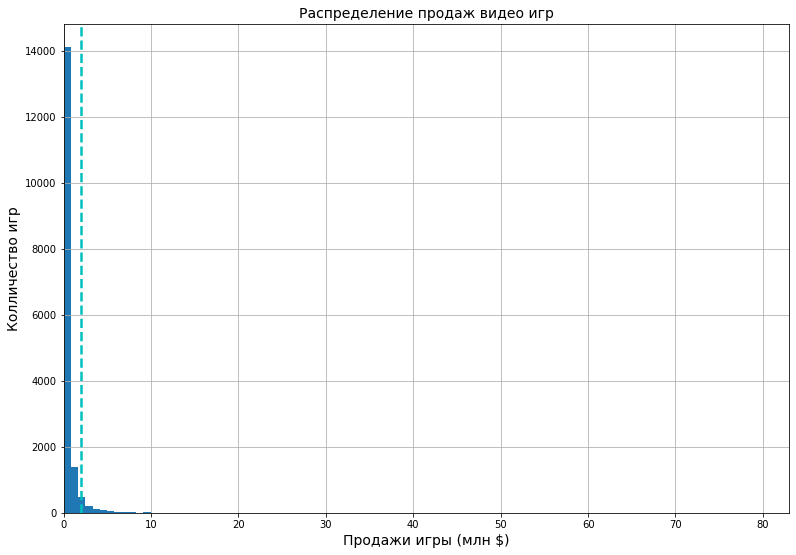

In [6]:
fig,ax = plt.subplots(figsize = (13,9))
df.Global_Sales.hist(bins = 100,ax = ax)
ax.set_xlim([0,83])
ax.set_title('Распределение продаж видео игр',fontsize = 14)
ax.set_ylabel('Колличество игр',fontsize = 14)
ax.set_xlabel('Продажи игры (млн $)',fontsize = 14)
ax.axvline(2, color='c', linestyle='dashed', linewidth=2.5)
plt.show()

Видно, что абсолютное большинство игр в датасете имели продажи менее 2 миллионов.

Сформируем датасет, состоящий из суммарных продаж игр за год, год выпуска игр, колличества выпущенных за год игр

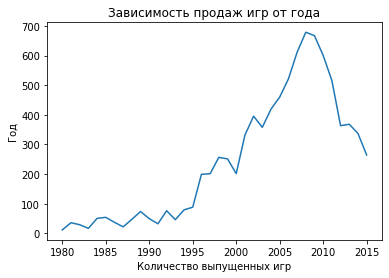

In [7]:
sales = df.groupby(by='Year')['Global_Sales'].sum() #количество покупок игр для каждого года
sales = sales[sales.index<2016]# Информация за 2016 и тд год не полная, поэтому не включаю ее
plt.plot(sales),sales.shape
plt.title(u'Зависимость продаж игр от года')
plt.xlabel(u'Количество выпущенных игр')
plt.ylabel(u'Год')
plt.show()

Видно, что ряд является мультиколлинеарным. Причем тренд возрастает до 2008 года, а затем начинает падать

Кажется очевидным, что на проаджи влияет и количество игр, выпущенных за год:

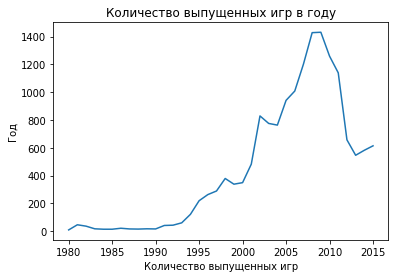

In [8]:
numbers = df.groupby(by='Year')['Name'].count()
numbers = numbers[numbers.index<2016]
plt.plot(numbers),numbers.shape
plt.title(u'Количество выпущенных игр в году')
plt.xlabel(u'Количество выпущенных игр')
plt.ylabel(u'Год')
plt.show()

Объединим данные датафреймы

In [9]:
all_par = pd.concat([sales,numbers],axis = 1)
all_par.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 36 entries, 1980.0 to 2015.0
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Global_Sales  36 non-null     float64
 1   Name          36 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 864.0 bytes


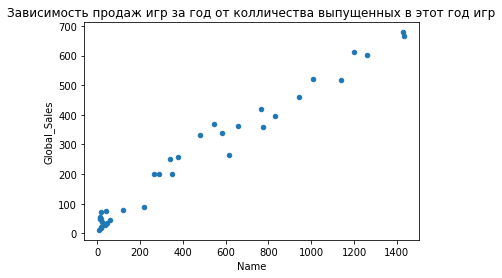

In [10]:
all_par.plot.scatter(x = 'Name',y = 'Global_Sales')# действительно есть неплохая зависимость
plt.title(u"Зависимость продаж игр за год от колличества выпущенных в этот год игр")
plt.show()

Исходя из данного графика видно, что общие продажы в мире линейно зависят от количества выпущенных популярных игр

## Исследуем распределение целевого признака

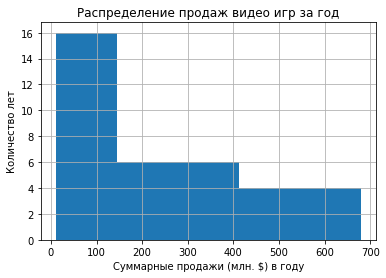

In [11]:
sales.hist(bins = 5)
plt.title(u"Распределение продаж видео игр за год")
plt.ylabel(u"Количество лет")
plt.xlabel(u"Суммарные продажи (млн. $) в году")
plt.show()

Распределение приближено похоже на Пуассона(хоть и непрерывное), проверим данную гипотезу
Из метода максимального правдободобия известно, что параметр $\theta = \frac{\sum_{i=1}^n x_i}{n}$ является оценкой параметра $\lambda$ распределения Пуассона, причем, легко увидеть, что $\theta$ есть средняя выборочнаяя, то есть не смещенная и состоятельная оценка.  
Найдем среднее выборочное:

In [12]:
mean_var = sales.mean()
mean_var

243.03027777777652

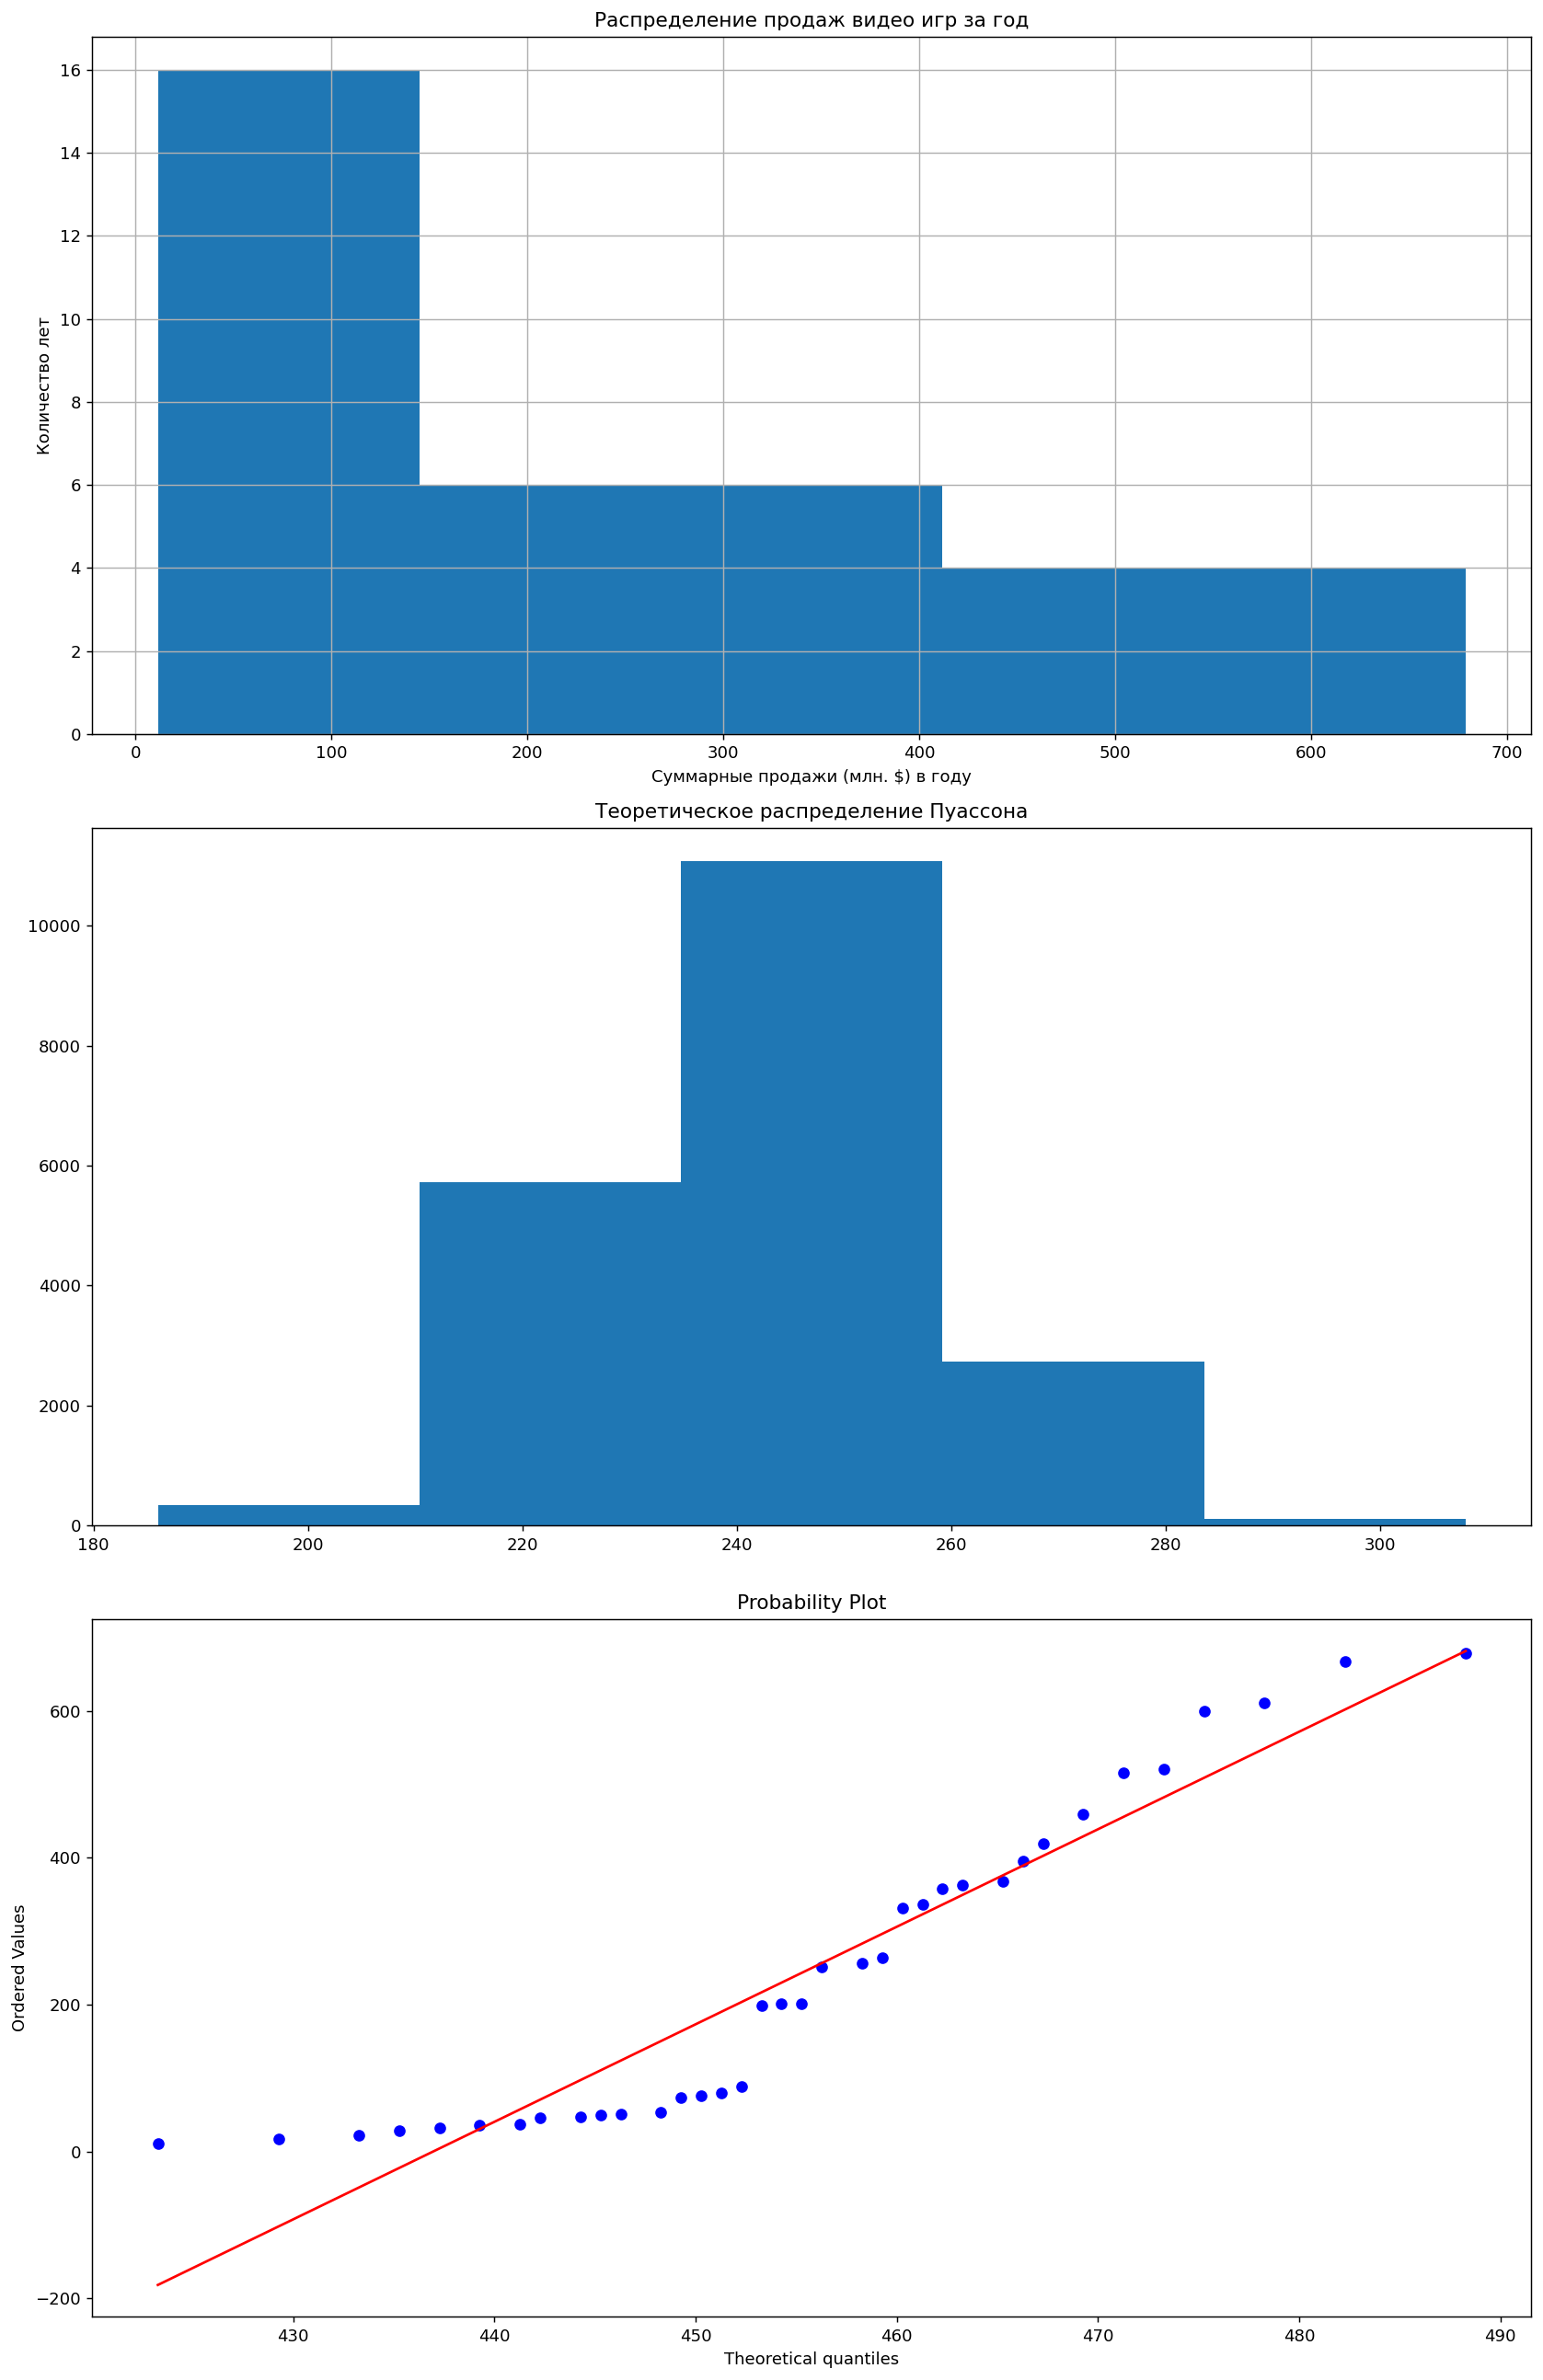

In [13]:
scale_var = sales.std()

x = np.linspace(sales.min(),sales.max(),sales.shape[0])
poisson_rv = stats.poisson(mean_var)
poisson_pop = poisson_rv.rvs(size = 20000)

#y_cdf = stats.poisson.cdf(x,mean_var)
fig,ax = plt.subplots(3,figsize = (13,20),dpi = 130)
sales.hist(bins = 5,ax = ax[0])
ax[0].set_title(u"Распределение продаж видео игр за год")
ax[0].set_ylabel(u"Количество лет")
ax[0].set_xlabel(u"Суммарные продажи (млн. $) в году")
ax[1].set_title(u"Теоретическое распределение Пуассона")
ax[1].hist(poisson_pop,bins = 5)
res = stats.probplot(sales.values, dist = "poisson", sparams = (mean_var,scale_var),plot = ax[2])
fig.tight_layout()
#ax.plot(x,y_cdf,label = 'cdf',color = 'r')

По данному графику видно, что распределение сильно отличается от распределения Пуассона. Применим критейри Колмогорова Смирнова для проерки того, действительно распределение c.в не является Пуассоновским с $\lambda = mean\_var$. Уровень значимости 5%.
1. H0 - распределение с.в это распределение Пуассона с $\lambda = mean\_var$
2. H1 - распределение с.в это не распределение Пуассона с $\lambda = mean\_var$

In [14]:
stats.kstest(sales,'poisson',args = (mean_var,))

KstestResult(statistic=0.5246571022330325, pvalue=9.311587601949132e-10)

p<<0.05, соответственно, гипотеза H0 отвергается. Стоит, однако, заметить, что пока нельзя точно отрицать, что распределение с.в. не принадлежит множеству Пуассоновских, так как проверка была проведена лишь для определенного $\lambda$

Продолжим поиски. Сравним с экспоненциальным распределением  
Оценка параметра $\lambda$ экспоненциального распределения = $\theta = \frac{n}{\sum_{i = i}^n x_i}$, причем $E = \frac{1}{\lambda},D = \frac{1}{\lambda ^2}$.

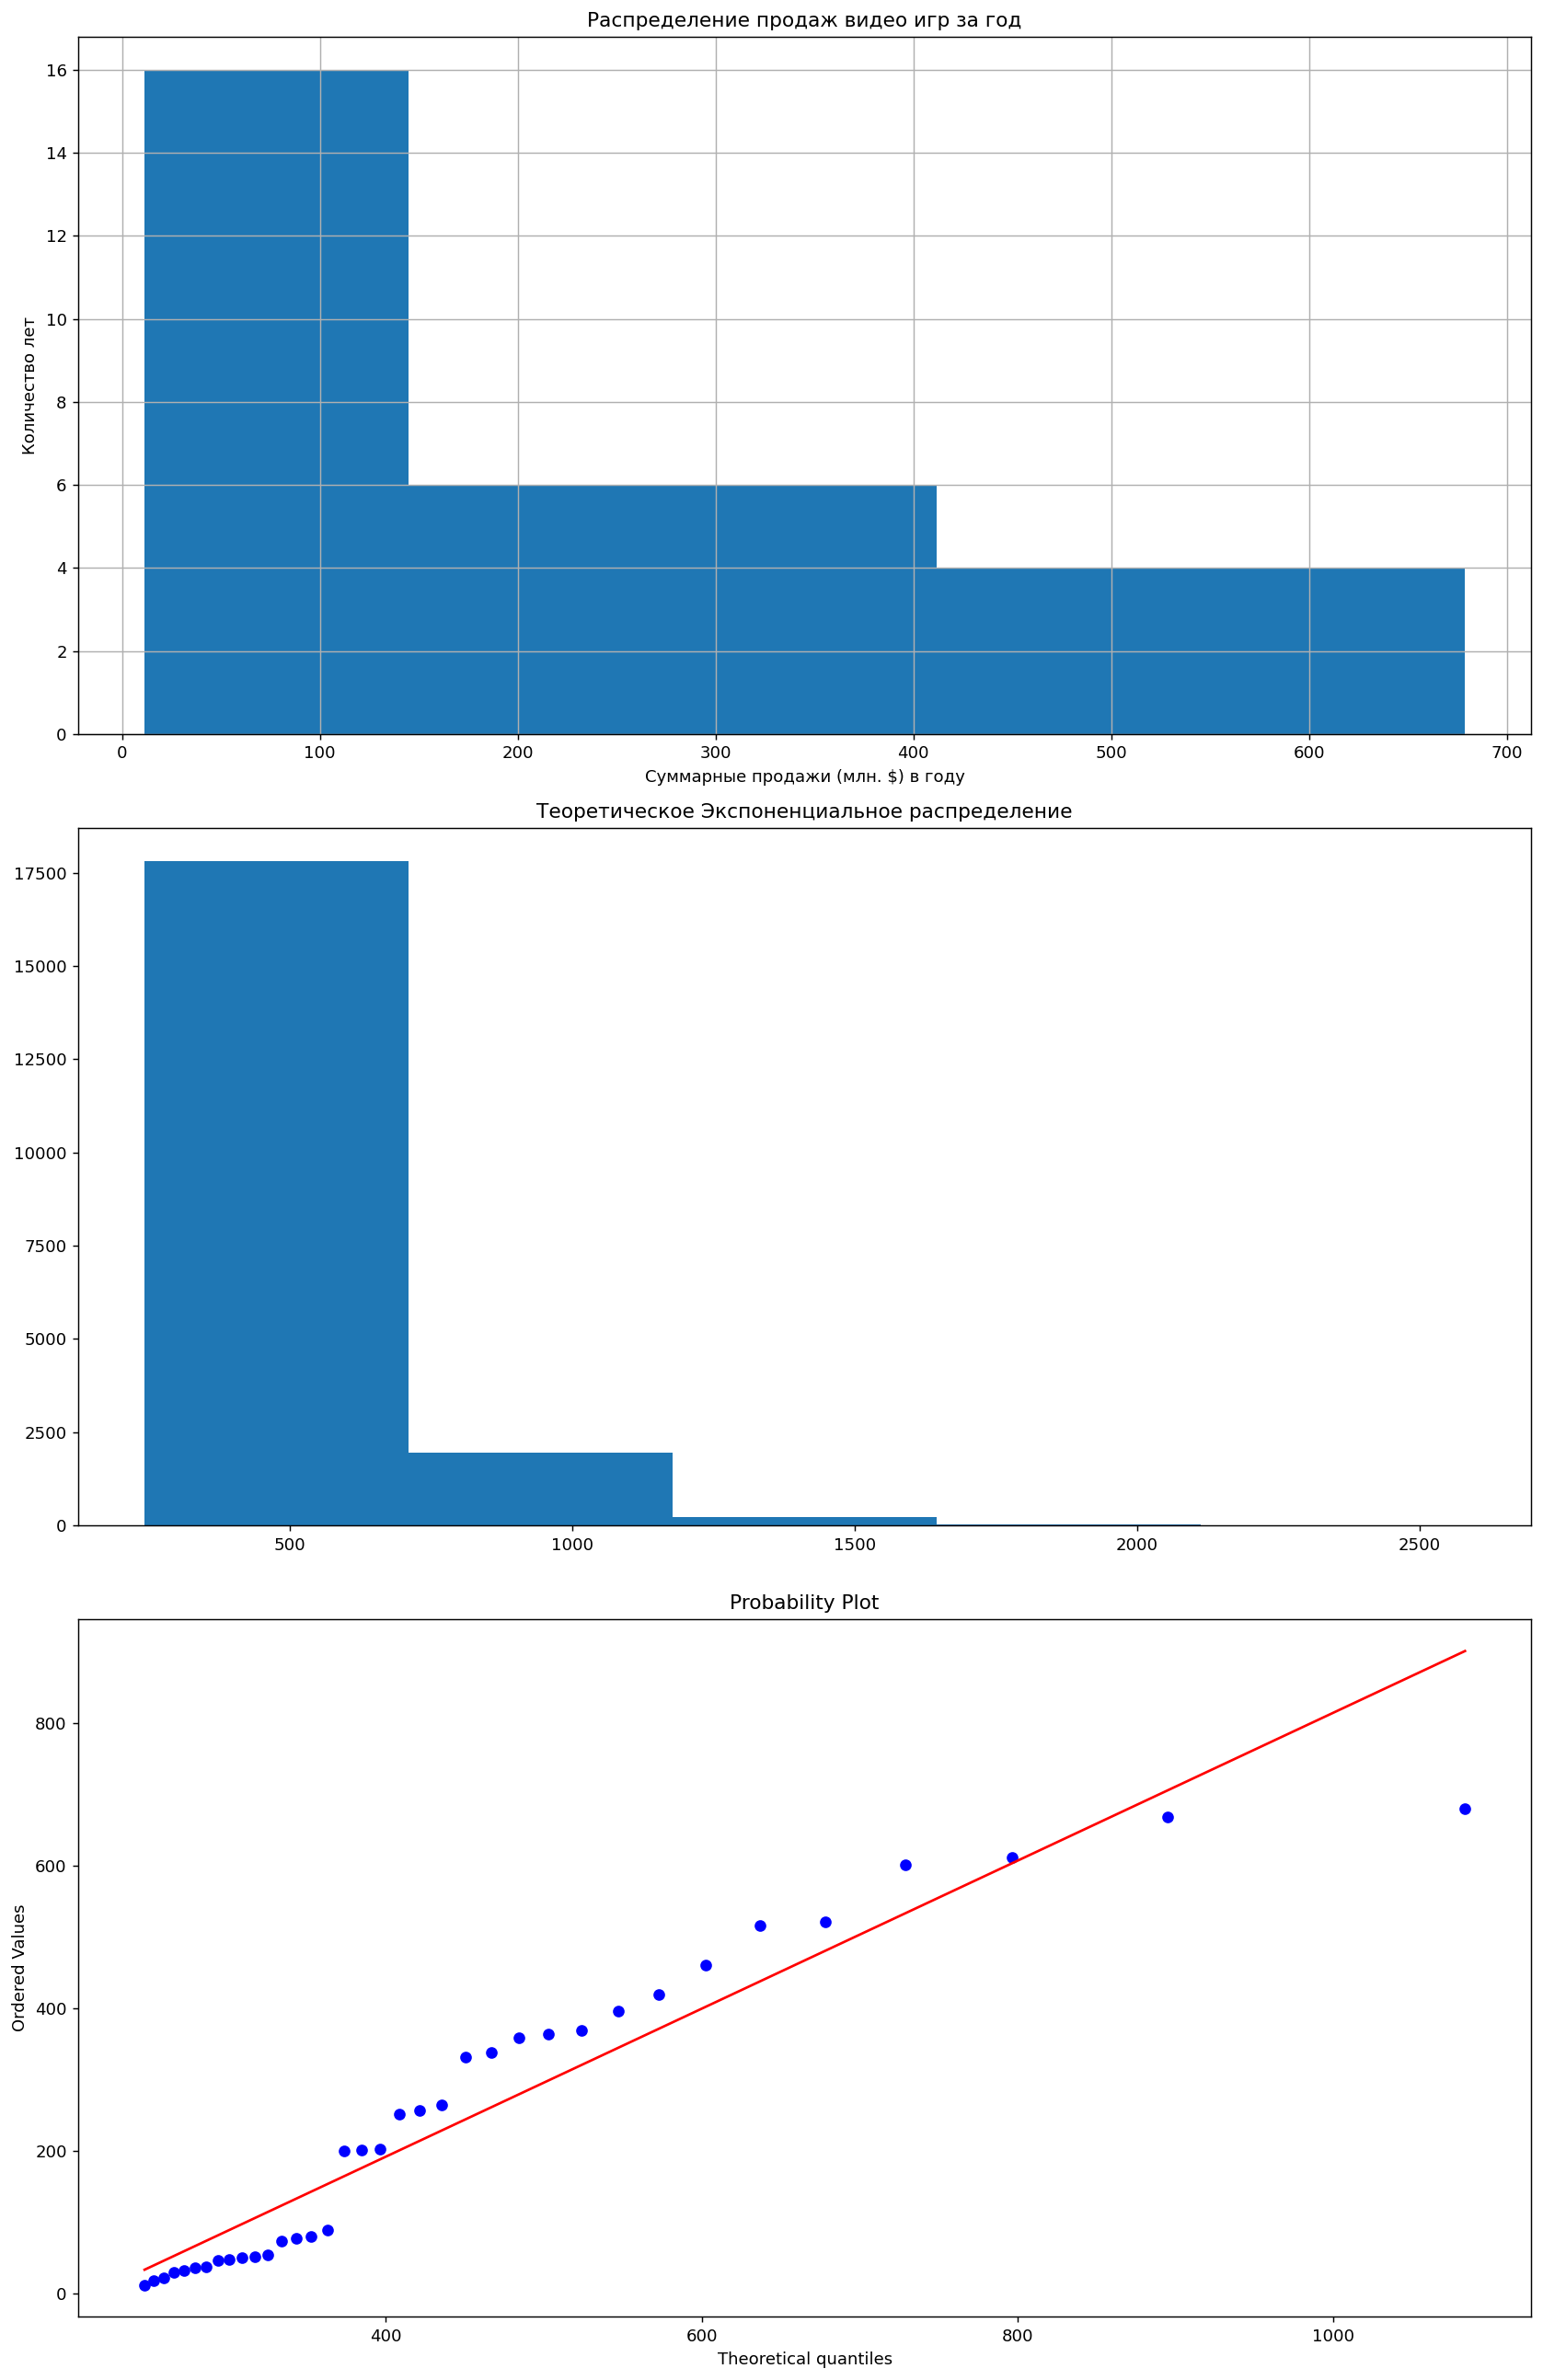

In [15]:
x = np.linspace(sales.min(),sales.max(),sales.shape[0])
poisson_rv = stats.expon(loc = mean_var, scale = scale_var)
expon_pop = poisson_rv.rvs(size = 20000)

#y_cdf = stats.poisson.cdf(x,mean_var)
fig,ax = plt.subplots(3,figsize = (13,20),dpi = 130)
sales.hist(bins = 5,ax = ax[0])
ax[0].set_title(u"Распределение продаж видео игр за год")
ax[0].set_ylabel(u"Количество лет")
ax[0].set_xlabel(u"Суммарные продажи (млн. $) в году")
ax[1].set_title(u"Теоретическое Экспоненциальное распределение")
ax[1].hist(expon_pop,bins = 5)
stats.probplot(sales.values, dist = "expon", sparams = (mean_var,scale_var),plot = ax[2])
fig.tight_layout()
fig.show()
#ax[1].set_xlim([sales.min(),sales.max()])
#ax.plot(x,y_cdf,label = 'cdf',color = 'r')

Для провекри принадлежности распределения с.в к семейству экспоненциальных, воспользуемся непараметрическим критерием Андерсона с уровнем значимости 5% 

1. H0 - распределение с.в принадлежит множеству экспоненциальных.
2. H1 - распределение с.в не принадлежит множеству экспоненциальных.

Критерий применим при объеме выборки n>25. Условие выполняется

In [16]:
stats.anderson(sales,dist='expon')

AndersonResult(statistic=0.9995036313319403, critical_values=array([0.907, 1.06 , 1.319, 1.58 , 1.925]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Так как значение статистики меньше значения критической статистики для уровня значимости 5%(0.99<1.319) мы не можем отвергнуть нулевую гипотезу о том, что семейство распределений с.в. принадлежит множеству экспоненциальных

Наиболее близко выглядит именно экспоненциальное распределение(хоть оно и смещано). Стоит отметить, что распределение целевой переменной априори не может быть нормальным, так как вероятность значения меньше 100000(0.1) просто равна 0.

Однако, все-таки проверим, точно ли распределение случайной величины является не нормальным. Проверим это с помощью критерия Шапиро-Улка с уровнем значимости 5%:

In [17]:
stats.shapiro(sales)

(0.8805773258209229, 0.0010473866714164615)

p<0.05, соответственно нулевая гипотеза о нормальности распределения отвергается.

### Визуализируем времянной ряд для получение инсайтов о сезонности и тренеде

Попробуем подобрать тренд выполняя декомпозицию ряда:

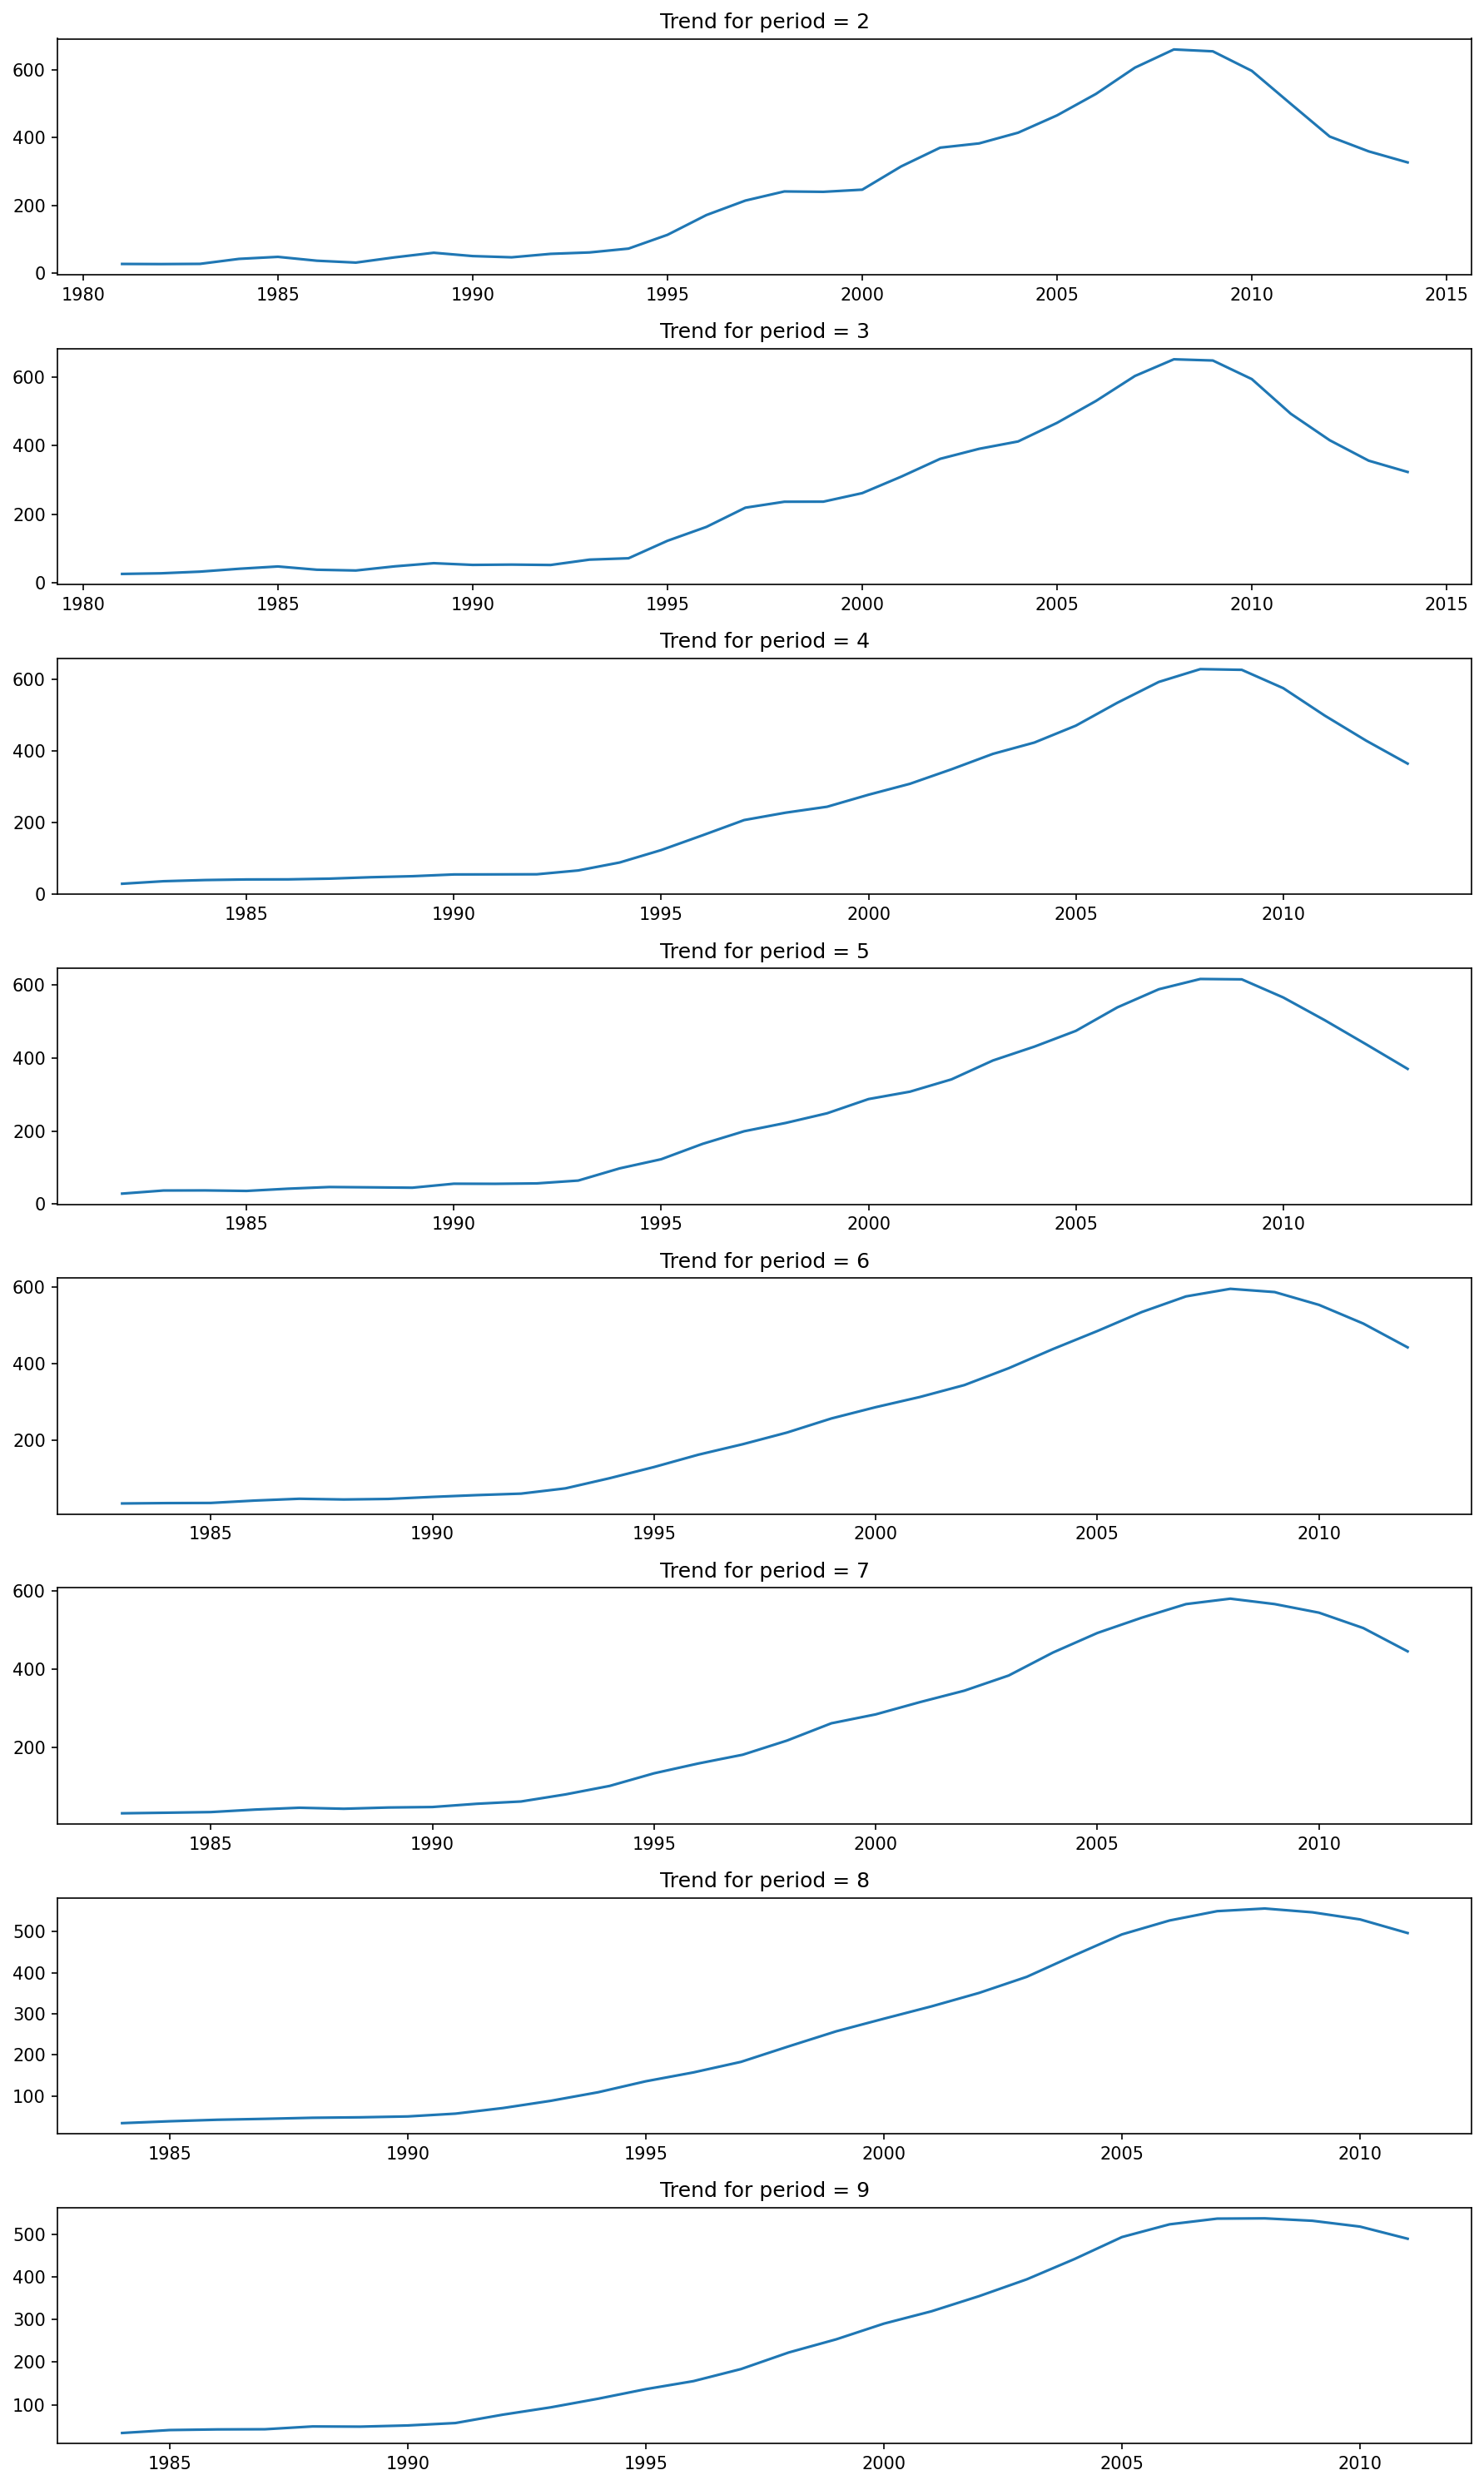

In [18]:
fig,axes = plt.subplots(8,figsize = (12,20),dpi = 150)
for i in range(8):
    result = sm.tsa.seasonal_decompose(sales, model='multiplicative',freq= i+2)
    axes[i].plot(result.trend)
    axes[i].set_title('Trend for period = {}'.format(i+2))
fig.tight_layout()

Видно, что наилучшее сглаживание получается при периоде 4, 6 и 8.  
Рассмотрим перио равный 4:

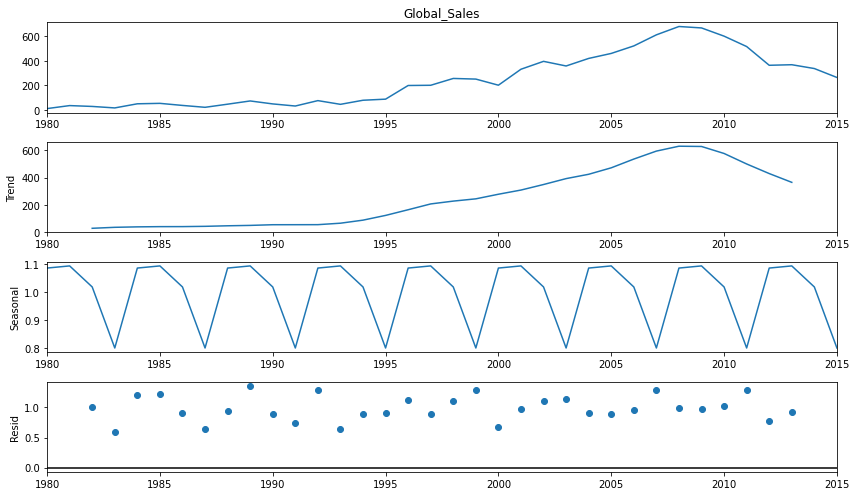

In [19]:
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(sales, model='multiplicative',freq= 4)
result.plot()
plt.show()

Выглядит не плохо. Стоит оценить распределение остатков. Пострим Q-Q график и воспользуемся критерием Шапиро-Уилка с критерием значимости 0.05

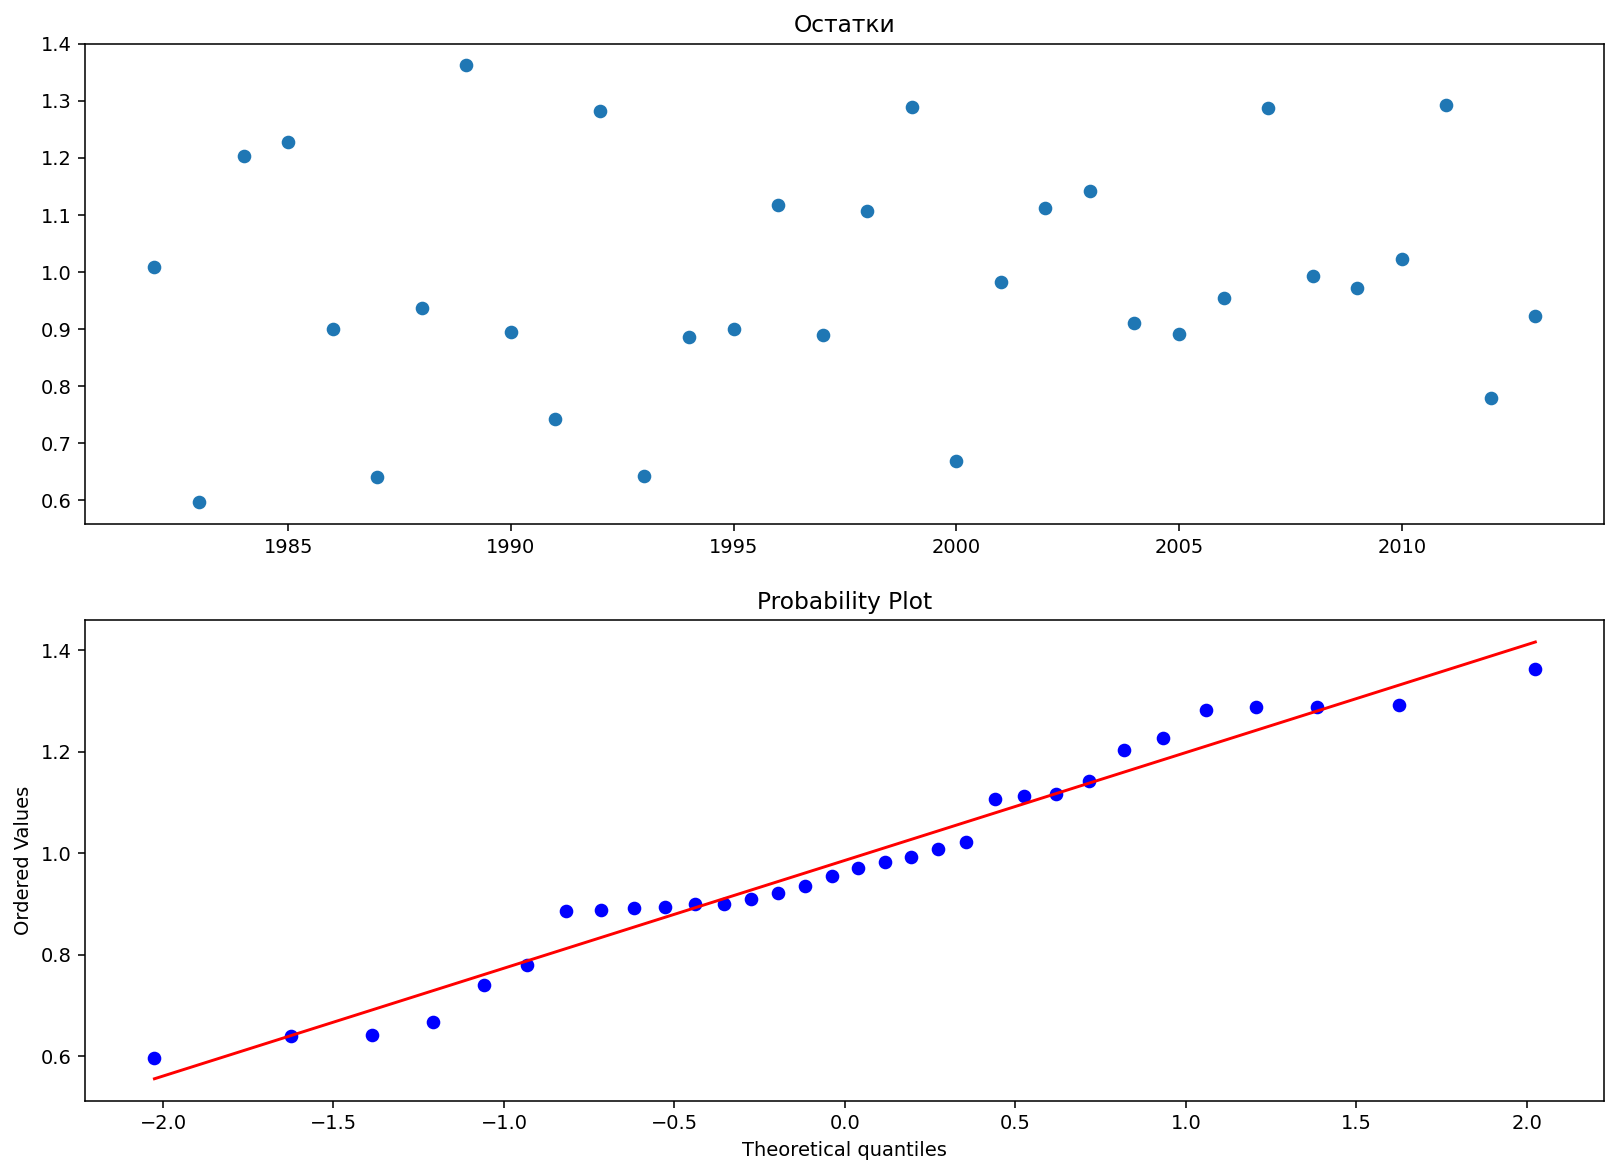

Тест Шапиро-Уилка: (0.9583892822265625, 0.2480337917804718)


In [20]:
fig,ax = plt.subplots(2,figsize = (14,10),dpi = 140)
ax[0].scatter(result.trend.index,result.resid.values)
ax[0].set_title(u'Остатки')
stats.probplot(result.resid.dropna(), dist = "norm", plot = ax[1])
plt.show()
print('Тест Шапиро-Уилка:',stats.shapiro(result.resid.dropna()))

р>0.05, соответственно нулевая гипотеза о нормальности распределения не отвергается. Это говорит о верном выборе периода сезонности.

Проверим также периоды 6 и 8:

Рассмотрим период, равный 6:

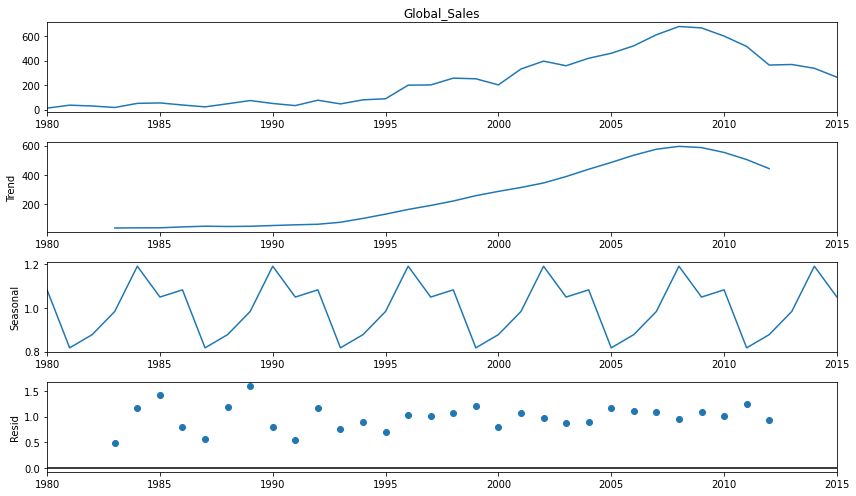

In [21]:
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(sales, model='multiplicative',freq= 6)
result.plot()
plt.show()

Сезонность выглядит куда хуже, оценим распределение ошибки

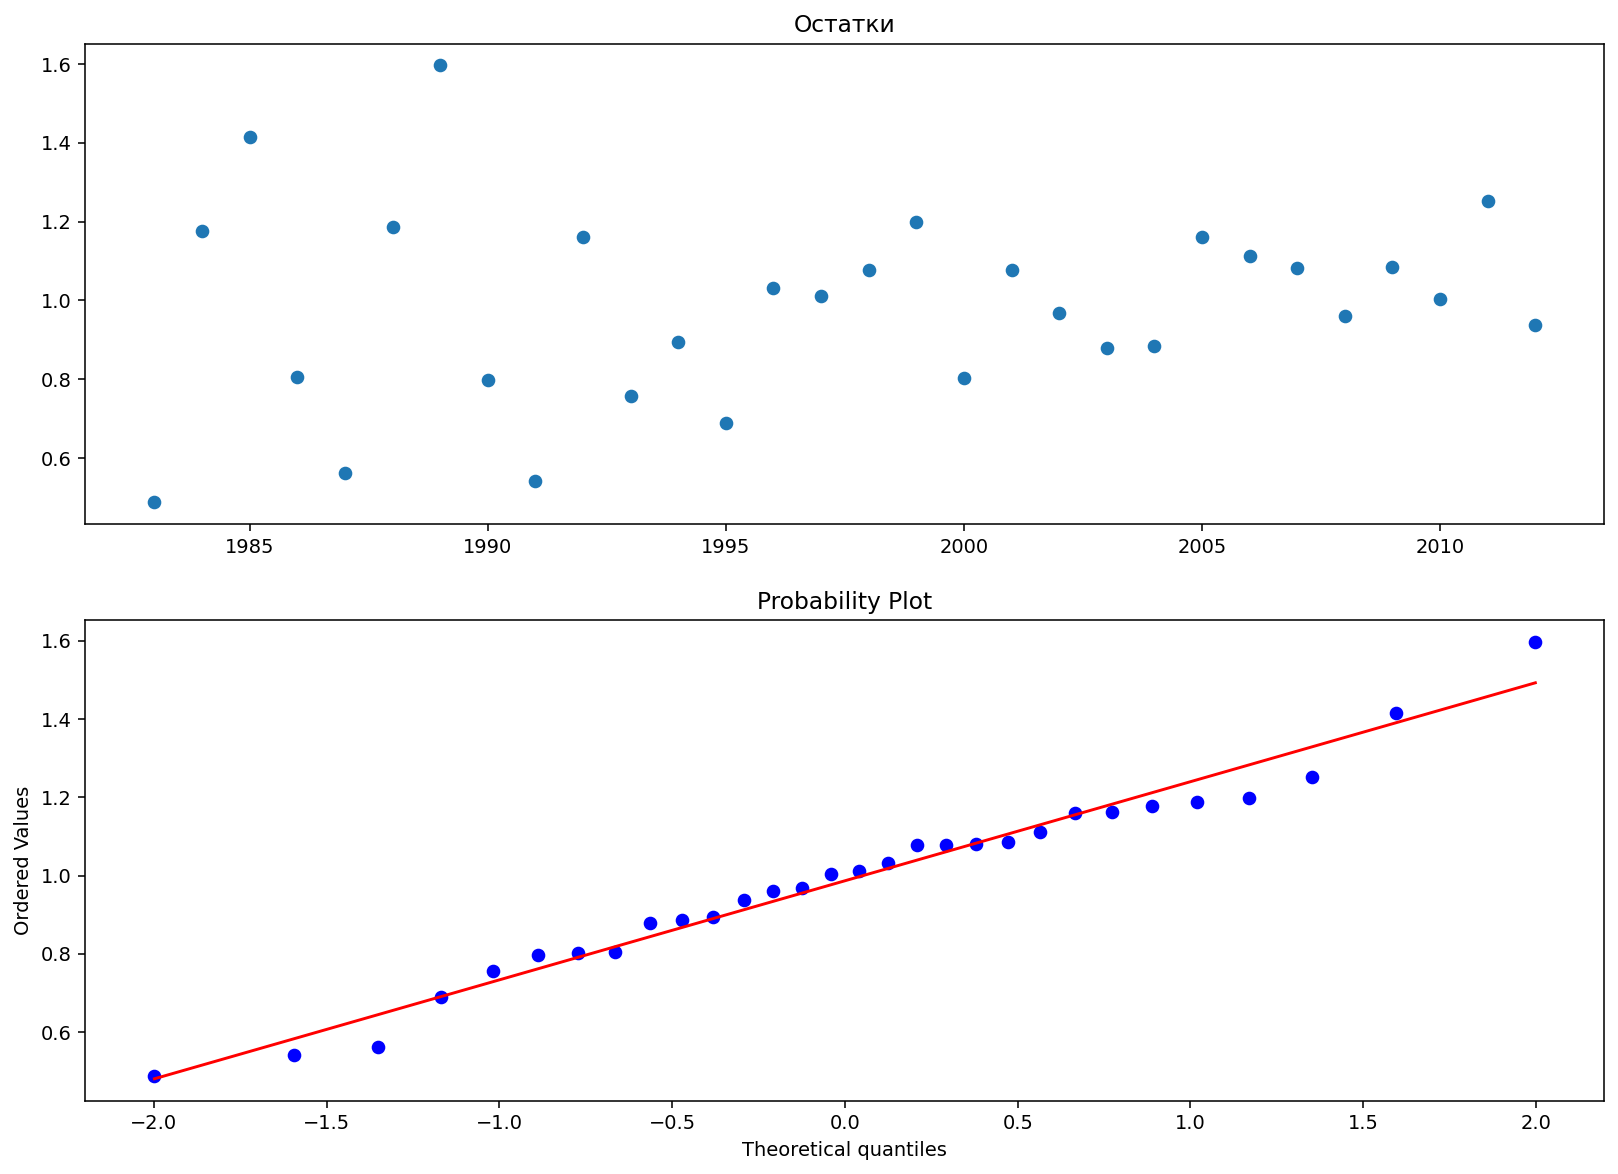

Тест Шапиро-Уилка: (0.9779448509216309, 0.7686741948127747)


In [22]:
fig,ax = plt.subplots(2,figsize = (14,10),dpi = 140)
ax[0].scatter(result.trend.index,result.resid.values)
ax[0].set_title(u'Остатки')
stats.probplot(result.resid.dropna(), dist = "norm", plot = ax[1])
plt.show()
print('Тест Шапиро-Уилка:',stats.shapiro(result.resid.dropna()))

Снова разность распределена нормально. Теперь рассмотрим период равный 8

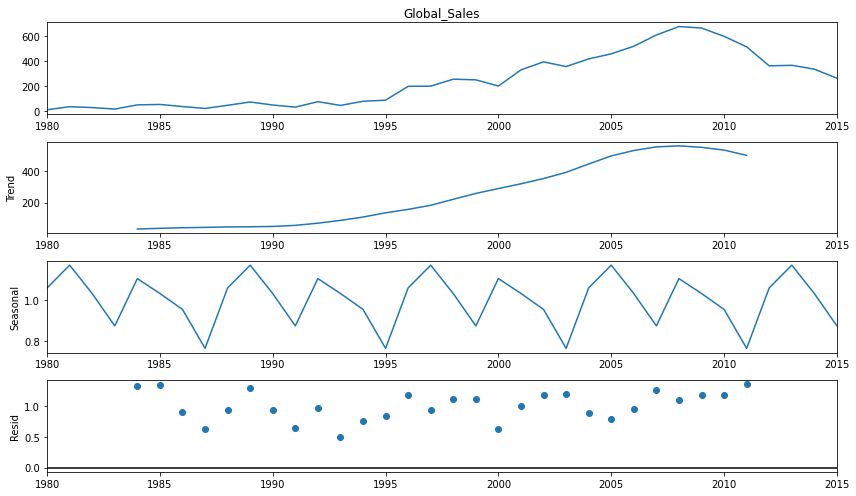

In [23]:
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(sales, model='multiplicative',freq= 8)
result.plot()
plt.show()

Сезоны почти разделились, что говорит о неверном выборе периода

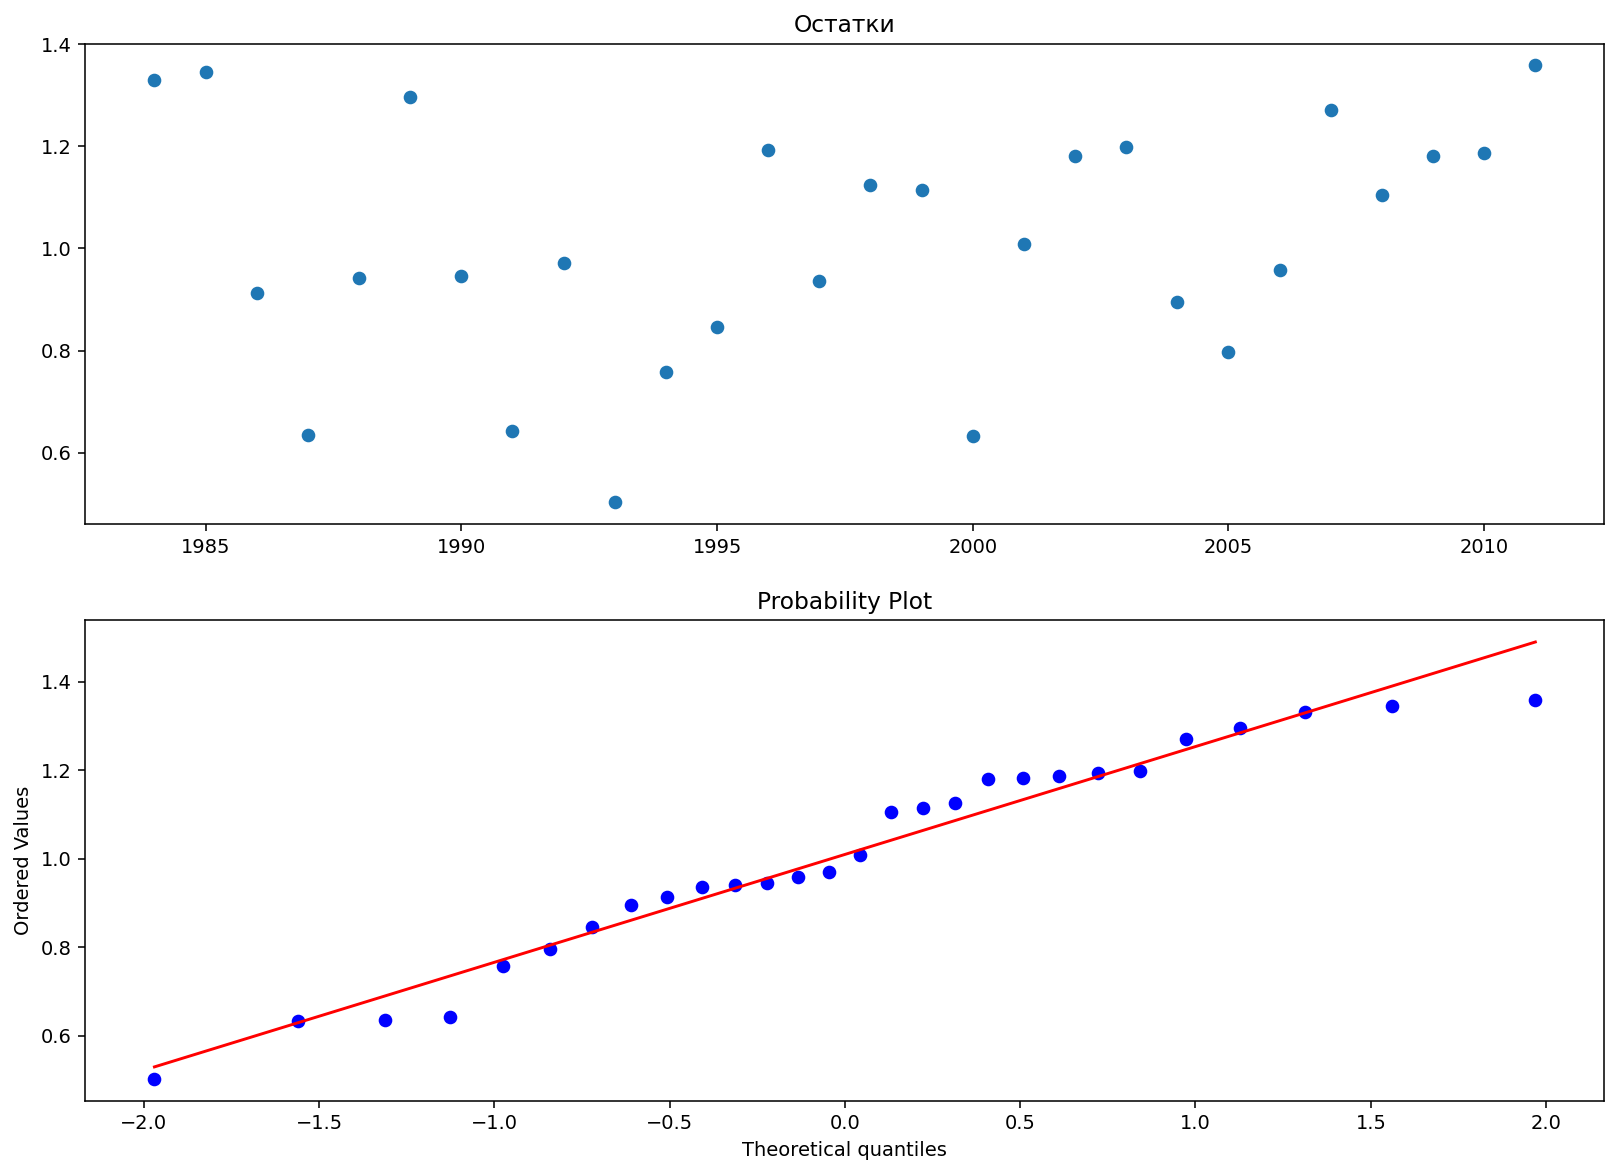

Тест Шапиро-Уилка: (0.9539248943328857, 0.24824869632720947)


In [24]:
fig,ax = plt.subplots(2,figsize = (14,10),dpi = 140)
ax[0].scatter(result.trend.index,result.resid.values)
ax[0].set_title(u'Остатки')
stats.probplot(result.resid.dropna(), dist = "norm", plot = ax[1])
plt.show()
print('Тест Шапиро-Уилка:',stats.shapiro(result.resid.dropna()))

Разность снова нормальна. Это довольно просто обосновать, так как период сезонности в 2 раза больше 4

Для обоснования того, что на сезонность влияет именно новых платформ - рассмотрим гистограмму количества проадж игр в зависимости от платформы(будет рассмотрена суммарное количество продаж за 2 самых прибыльных года):

In [25]:
def realize(dfr):
    platform_name = dfr.Platform.unique()
    counts = []
    for name in platform_name:
        k = dfr[dfr.Platform == name].groupby(by='Year')['Global_Sales'].sum().values
        counts.append(k[k.argsort()[-2:]].sum())
    a = [{'Platform' : platform_name[i],
        'count_sales' : counts[i]} for i in range(platform_name.size)]
    return pd.DataFrame(a)
        

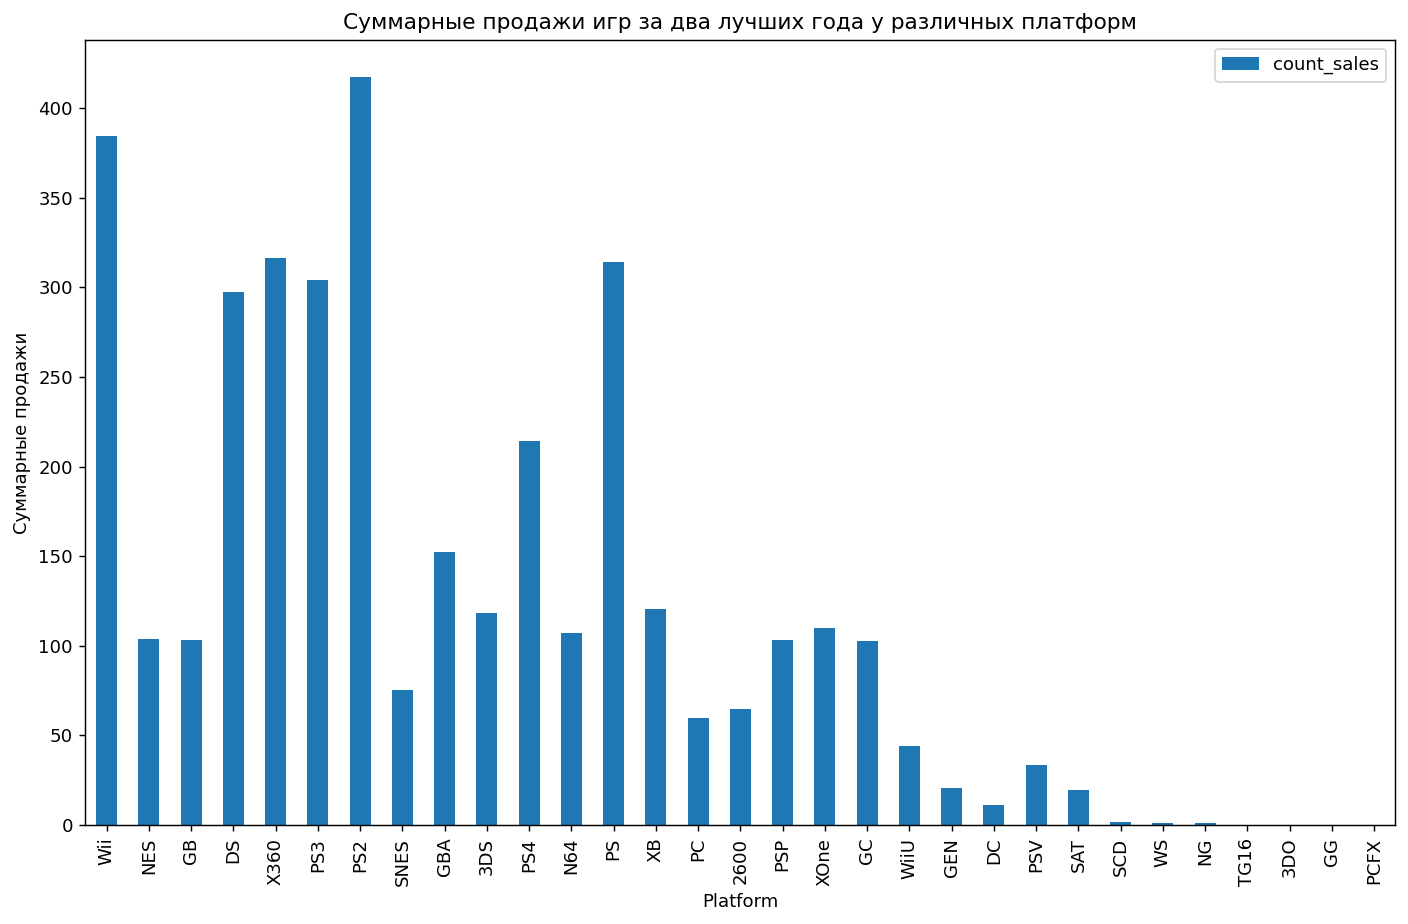

In [26]:
counts = realize(df)
fig,ax = plt.subplots(figsize = (13,8),dpi = 130)
counts.plot.bar(x ='Platform',y = 'count_sales', ax = ax)
ax.set_title(u'Суммарные продажи игр за два лучших года у различных платформ')
ax.set_ylabel(u'Суммарные продажи')
plt.show()

Известно, что суммарные продажи игр на консолях максимальны именно в годы их выхода. Соответственно можно утверждать о том, что выход новой платформы, типо XBox, Wii, PS очень сильно вляют на рынок видео-игр, создавая сезонность. Стоит заметить, что влияние выхода таких платформ, как Wii и PS2 настолько большое, что в суммарные продажи игр на данных платформах намного выше, чем на Персональном компьютере за всю историю(имеется ввиду, что 2 лучших года для игр на ПК выбирались за всю историю видео игр)

### Итог по сезонности:
1. В ходе проведенного исследования сезонности было получено, что сезонность ряда равна 4-м.
2. Сезонность 6 и 8 выглядит куда хуже, хоть распределение разности у них опять же нормально.
3. Обосновать данную сезонность можно тем, что в среднем самые популярные игровые платформы (X_box,SonyPlayStation, Wii) в среднем выходят раз в 4 года, если учитывать, что они выпускаются в разные периоды времени.

## Рассмотрим зависимость количества продаж в мире от количества выпущенных игр в году

Оценим распределение количества вущенных игр:

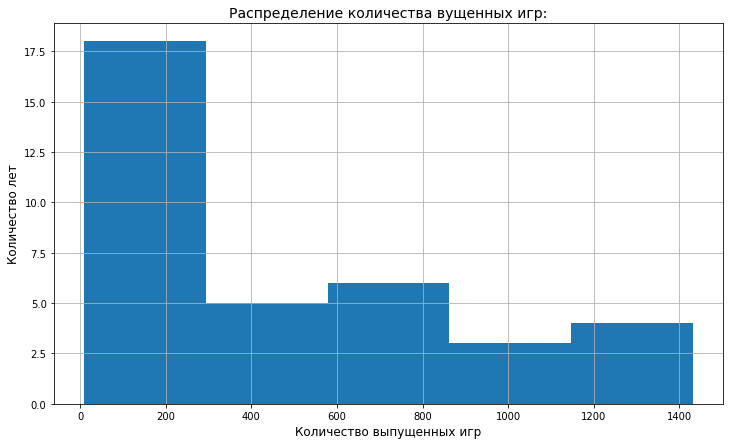

In [27]:
numbers.hist(bins = 5)
plt.title("Распределение количества вущенных игр:",fontsize = 14)
plt.ylabel("Количество лет",fontsize = 12)
plt.xlabel("Количество выпущенных игр",fontsize = 12)
plt.show()

Проверим, является ли распределение нормальным с помощью критерия Шапиро-Уилка с уровнем значимости 5%:

In [28]:
stats.shapiro(numbers)

(0.8532783389091492, 0.00022665144933853298)

p<0.05, соответственно нулевая гипотеза о нормальности распределения количества выпускаемых игр по годам отвергается.

Сравним с лог экспоненциальным распределением:

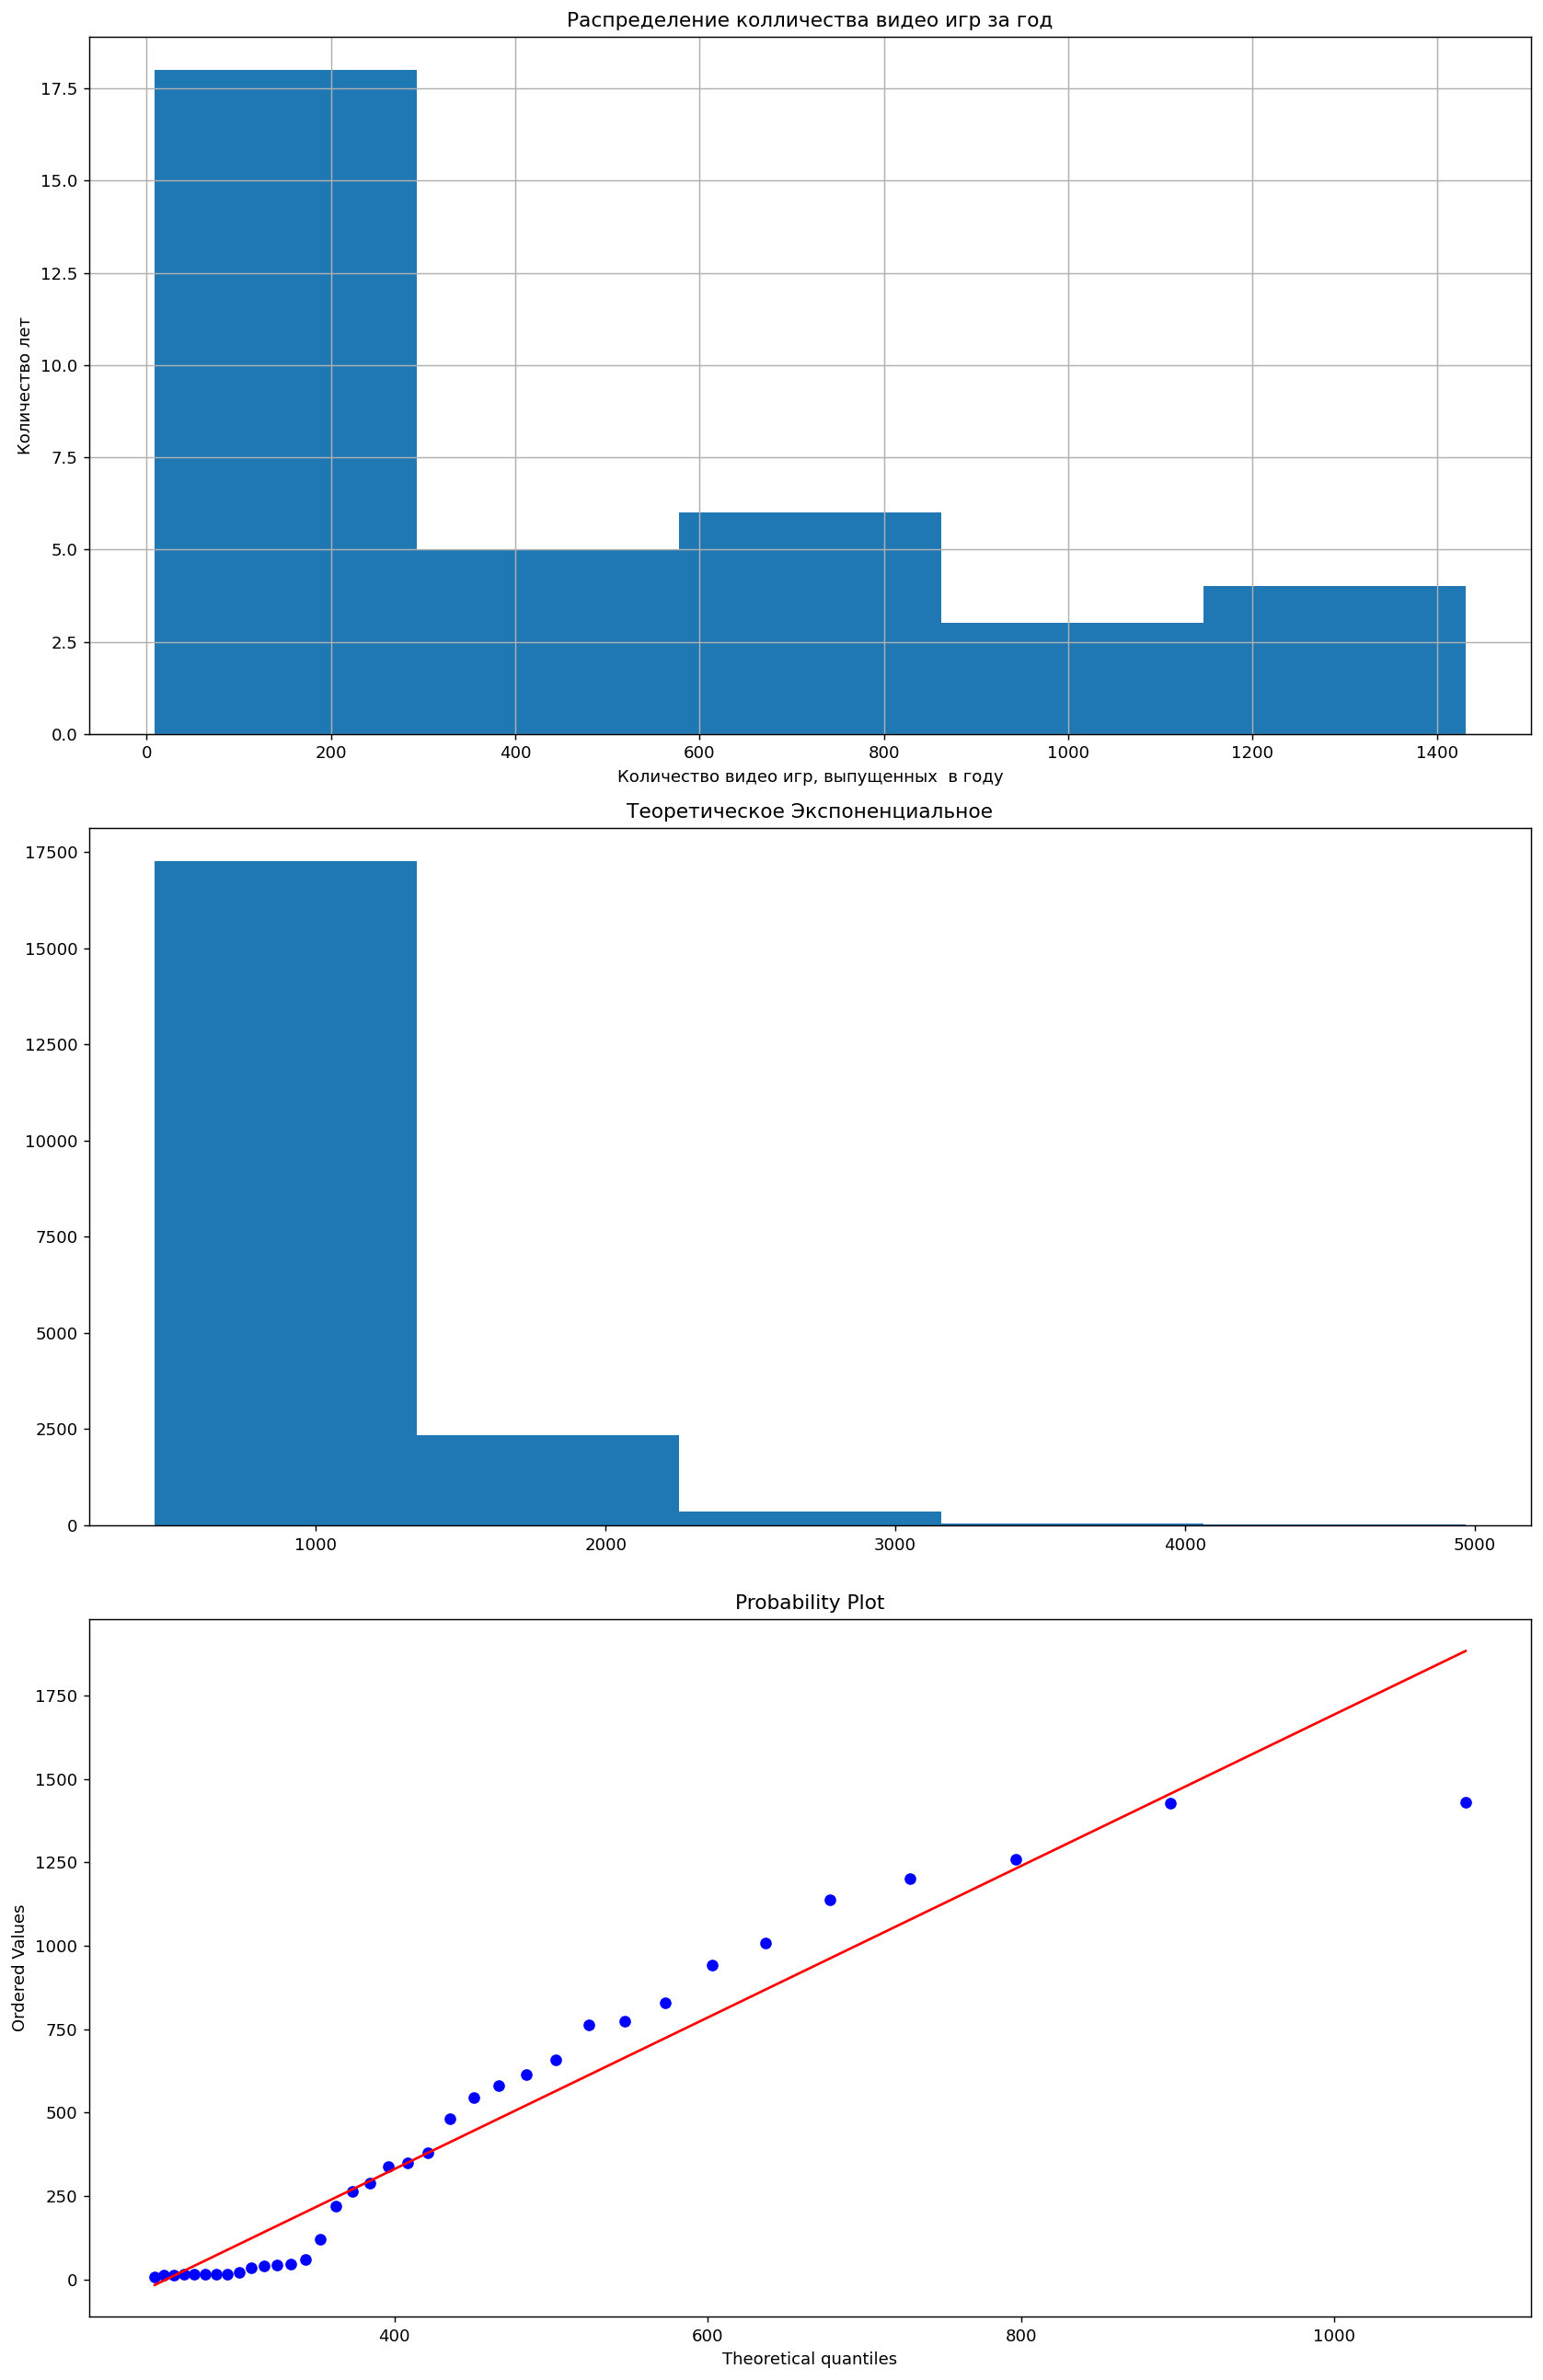

In [29]:
mean_num = numbers.mean()
skeal_num = numbers.std()
x = np.linspace(numbers.min(),numbers.max(),numbers.shape[0])
poisson_rv = stats.expon(loc = mean_num, scale = skeal_num)
poisson_pop = poisson_rv.rvs(size = 20000)

#y_cdf = stats.poisson.cdf(x,mean_var)
fig,ax = plt.subplots(3,figsize = (13,20),dpi = 130)
numbers.hist(bins = 5,ax = ax[0])
ax[1].hist(poisson_pop,bins = 5)
ax[0].set_title(u"Распределение колличества видео игр за год")
ax[0].set_ylabel(u"Количество лет")
ax[0].set_xlabel(u"Количество видео игр, выпущенных  в году")
ax[1].set_title(u"Теоретическое Экспоненциальное")
stats.probplot(numbers.values, dist = "expon", sparams = (mean_var,scale_var),plot = ax[2])
fig.tight_layout()
plt.show()

Видно, что распределение довольно похоже на экспоненциальное. Опять же проверим эту гипотезу с помощью критерия Андерсона с уровнем значимости 5%. n>25 выполняется

In [30]:
stats.anderson(numbers,dist='expon')

AndersonResult(statistic=4.043763899011417, critical_values=array([0.907, 1.06 , 1.319, 1.58 , 1.925]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Так как значение статистики больше критического для уровня значимости 5%(4.043763899011417 > 1.319) нулевая гипотеза о принадлежности распределения с.в к множеству экспоненциальных отклоняется

Так как и продажи игр за год, и количество выпущенных игр не являются нормальными --- для выявления корреляции между данными случайными величинами воспользуемся корреляцией Спирмена.  
Нулевая гипотеза заключается в том, что данные величины не коррелируют. проверим данную гипотезу с уровнем значимости p = 0.05.

In [31]:
stats.spearmanr(sales,numbers)

SpearmanrResult(correlation=0.9372465901690068, pvalue=3.9946347835655365e-17)

p<<0.05, соответственно гипотеза о том, что данные с.в не коррелируют отвергаются

Построим линейную модель, для того чтобы лучше понять уровень зависимости

Intercept    40.426676
Name          0.456457
dtype: float64


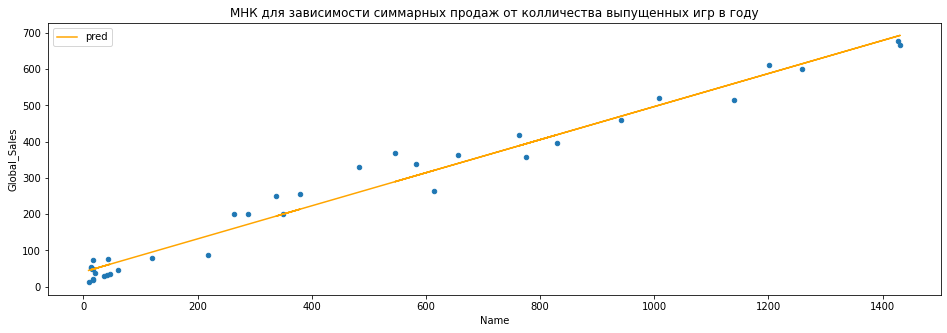

In [32]:
import statsmodels.formula.api as smf
model = smf.ols('Global_Sales~Name',data=all_par)
fitted = model.fit()
print(fitted.params)
all_par['pred'] = fitted.params[0] + fitted.params[1]*all_par['Name']
fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(111)

plt.title("МНК для зависимости симмарных продаж от колличества выпущенных игр в году")
all_par.plot.scatter('Name','Global_Sales',ax = ax1)
all_par.plot.line('Name','pred',ax = ax1,color = 'orange')
plt.show()

In [33]:
print (fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           Global_Sales   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1319.
Date:                Fri, 08 May 2020   Prob (F-statistic):           8.75e-29
Time:                        20:28:16   Log-Likelihood:                -177.15
No. Observations:                  36   AIC:                             358.3
Df Residuals:                      34   BIC:                             361.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.4267      7.969      5.073      0.0

Выводы:  
1. доля объясненной дисперсии очень высока(0.97), что может говорить о прямой и сильной зависимости
2. На p-value критерия Фишера не стоит обращать внимание, так как распределения признаков не нормально.
3. AIC и BIC достаточно малы и очень близки друг другу, что можно объяснить всего 1 параметром в зависимости.
4. По параметрам Skewness и Kurtosis видно, что остатки модели имеют распределение очень похожее на нормальное, что опять же говорит о корректонсти применения линейной модели.
5. тест Durbin-Watson показывает отсутсвие автокорелляции остатков модели, соответственно случайные отклонения независимы($1.55 \in (1,2)$)
6. Condition Number показывает, что модель очень чувствительна к входным данным, что можно объяснить появлением игр, количество продаж копий которых первышает в тысяци раз средние значения

Понятно, почему есть такая сильная зависимость. Учитываются только популярные игры, соответственно их количество напрямую влияет на множество проданных копий. небольшие отклонения наблюдаются, из-за того что иногда появляются очень популярные игры, которые могут влиять на количество проданных копий всех новых игр в году колоссально, к примеру, количество продаж игры "Wii sport" в 8 274 раза больше продаж игры "Turok", однако, по построенной гистограмме для количества проданных копий всех игр видно, что, в основном, все игры в датасете имели количество проданных копий менее миллиона.


## Проверка некоторых дополнительных статистических гипотез

### 1)проверка разности средних показателей продаж копий игр за год в мире для различных времянных промежутков

На графике зависимости количества проданных копий от года видно, что продажы сильно росли с течением времени. Стоит это проверить.

Выделим две подвыборки из датафрейма sales, раздели их по 1998 году:

In [34]:
split_val = sales.shape[0]//2
sales_bef = sales.iloc[:split_val]
sales_aft = sales.iloc[split_val:]

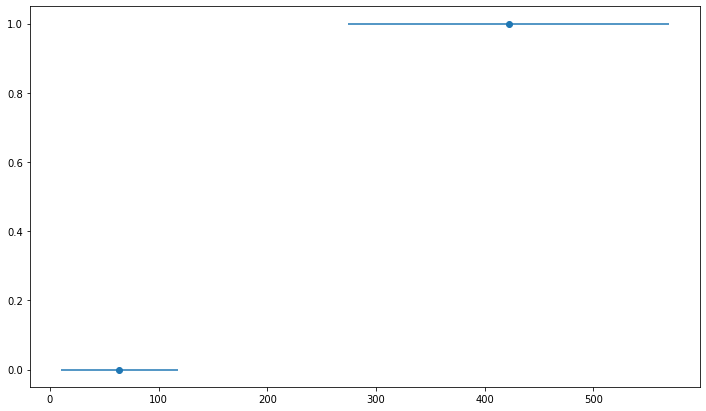

In [35]:
#Построим графики средних с дисперсией:
mean_bef = sales_bef.mean()
mean_aft = sales_aft.mean()
skale_bef = sales_bef.std()
skale_aft = sales_aft.std()
y = np.arange(2)

x = np.array([mean_bef,mean_aft])
e = np.array([skale_bef,skale_aft])
plt.errorbar(x, y, xerr = e, linestyle='None', marker='o')

#plt.errorbar( np.mean(x), y.shape[0] ,xerr =  np.std(x), linestyle='None', marker='o')

plt.show()

Из данного графика также видно, что средний уровень продаж сильно вырос в период с 1998 по 2015 год. 

Сформулируем гипотезу:
0. H0 - среднее количество продаж копий популярных видео игр не отличается между периодами с 1980 по 1997 и с 1998 по 2015
1. H1 - в период с 1998 по 2015 года продавалось в среднем больше игр, чем в период с 1980 по 1997

Будем считать, что выборки не связаны, предполагая, что комьюнити сильно изменялось(люди взрослели и переставали играть, начинали играть новые люди, предпочтения которых сильно изменились с ходом времени, количество геймеров увеличилось). Так как с.в имеет не нормальное распределение, объем выборок достаточно мал и выборки не связаны - воспользуемся двувыборочным критерием Манна-Уитни c уровнем значимости p = 0.05.


In [36]:
stats.mannwhitneyu(sales_aft,sales_bef, alternative = 'greater')

MannwhitneyuResult(statistic=324.0, pvalue=1.6139185053293612e-07)

p<<0.05 - Нулевая гипотеза отвергается и принимается гипотеза о том, что среднее количество копий, игр, выпущенных в период с 1998 по 2015 больше, чем с 1980 по 1997.  


Обосновать это достаточно просто. Понятно, что 1980 по 1997 не все люди иели возможность играть в видео-игры, да и количество выпускаемых тогда игр было куда меньше.

### 2)проверка разности среднего колличества выпущенных  игр за год в мире для различных времянных промежутков

Для подтверждения того, что количество выпускаемых игр выросло после 1997 года - сформулируем гипотезу
0. H0 - среднее количество выпущенных видео игр не отличается между периодами с 1980 по 1997 и с 1998 по 2015
1. H1 - в период с 1998 по 2015 года выпускалось,в среднем, больше игр, чем в период с 1980 по 1997.

Будем считать, что выборки не связаны, так как производители видеоигр и потребность в них сильно отличались между данными периодами. Также, как и в прошлый раз проверим гипотезу с помощью критерия Манна-Уитни(выборки маленькие(n<60), не связаны, с.в имеет не нормальное распределение), уровень значимости p = 0.05.


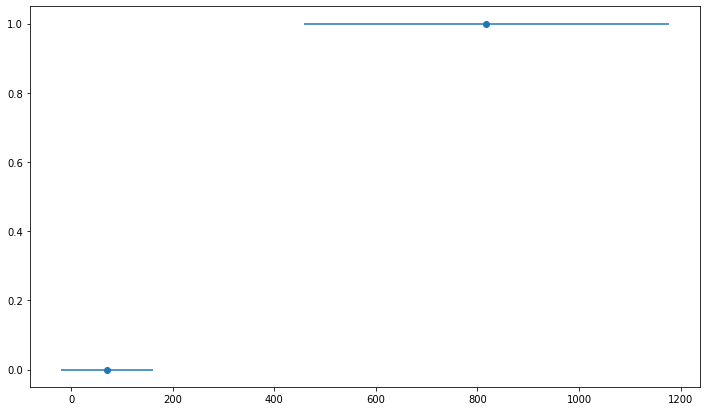

MannwhitneyuResult(statistic=324.0, pvalue=1.6055114580375442e-07)


In [37]:
numb_val = numbers.shape[0]//2
num_bef = numbers.iloc[:numb_val]
num_aft = numbers.iloc[numb_val:]
#Построим графики средних с дисперсией:
mean_bef_n = num_bef.mean()
mean_aft_n = num_aft.mean()
skale_bef_n = num_bef.std()
skale_aft_n = num_aft.std()
y = np.arange(2)

x = np.array([mean_bef_n,mean_aft_n])
e = np.array([skale_bef_n,skale_aft_n])
plt.errorbar(x, y, xerr = e, linestyle='None', marker='o')

#plt.errorbar( np.mean(x), y.shape[0] ,xerr =  np.std(x), linestyle='None', marker='o')

plt.show()
print(stats.mannwhitneyu(num_aft,num_bef, alternative = 'greater'))

Нулевая гипотеза вновь отвергается, что поять же говорит об увеличении количества выпускаемых игр.

Стоит заметить, что значения статистики для выбоки с количеством продаж и выборки с количеством выпускаемых игр одинаковые, что опять же говорит о синой зависимости мкжду данными показателями

### 3)Сравнение количества проданных игр для отдельной игры в разные промежутки времени.

Такая сильная зависимость количества проданных копий от количества выпущенных игр может говорить о независимости от времени. 

Проверим следующую гипотезу:
1. H0 - среднее количество продаваемых игр в период с 1980 по 1997 годы и с 1998 по 2015 не отличается при сравнении отдельных игр
2. H0 - в период с 1998 по 2015 среднее количество продаваемых копий для каждой игры больше, чем в период с 1980 по 1997

In [38]:
df_year = df.sort_values('Year',axis = 0)[df.Year<2016][['Year','Global_Sales']]
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15979 entries, 6896 to 15268
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          15979 non-null  float64
 1   Global_Sales  15979 non-null  float64
dtypes: float64(2)
memory usage: 374.5 KB


Количество игр с неизвеcтным годом мало относительно общего количества  - удалим их

In [39]:
df_bef = df_year[df_year.Year<1998]
df_aft = df_year[df_year.Year>=1998]

Проверим обе случайные величины на нормальность с помощью критерия Андерсона c уровнем значимости 5%(стоит отметить, что критерий Шапиро-Уилка при n>5000 может давать неверные значения p-value, поэтому и критерий Андерсона, который, как я понял, устойчив при увеличении n)

In [40]:
stats.anderson(df_bef.Global_Sales)

AndersonResult(statistic=236.32604373642198, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [41]:
stats.anderson(df_aft.Global_Sales)

AndersonResult(statistic=2901.3095422352235, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

В обоих случаях значение статистики гораздо больше критических, поэтому гипотезы о нормальности распределений отвергаются. 

Так как выборки большие и имеют не нормальное распределение воспользуемся знаковым критерием.

1. Н0 - выборки имеют одинаковые средние показатели продаж для игр
2. Н1 - это не так

In [42]:
from statsmodels.stats.descriptivestats import sign_test
sign_test(df_aft.Global_Sales.values[:100] - df_bef.Global_Sales[:100], 0)

(-17.5, 0.0005622082483570491)

p<0.05, соответственно, гипотеза об их равенстве отвергается

## Построение предсказания времянного ряда

### Построение линейной модели c использованием xgboost

В ходе проделанных исследований было выяснено, что целевой признак зависит от времени и количества выпущенных игр в году. Будем строить линейную модель с помощью xgboost, где признаками будут являться логи, взятые по сезонности и количество выпущенных игр

In [43]:
def cross_val(data,model):
    """
    Функция кросс валидации для модели
    """
    tscv = TimeSeriesSplit(n_splits=3) 
    errors = []
    for train_idx, test_idx in tscv.split(data.index):
        model.fit(data.drop('Global_Sales',axis = 1).iloc[train_idx],data.Global_Sales.iloc[train_idx])
        pred = model.predict(data.drop('Global_Sales',axis = 1).iloc[test_idx])
        errors.append(mean_absolute_error(data.Global_Sales.iloc[test_idx],pred))
    return np.average(errors)#,weights = np.arange(1,4))

In [44]:
Val = all_par.drop('pred',axis = 1)
Val["lag"] = Val.Global_Sales.shift(4)
tr_size = np.int64((Val.shape[0])*0.8)
Val_train = Val.iloc[:tr_size]
Val_test = Val.iloc[tr_size:]

In [45]:
Val_train.head()# Видно, что значения с NaN достаточно малы, а время с 1980 по 1984
          # не особо существенно, поэтому удалим их

,Global_Sales,Name,lag
Year,,,
1980.0,11.38,9,NaN
1981.0,35.77,46,NaN
1982.0,28.86,36,NaN
1983.0,16.79,17,NaN
1984.0,50.36,14,11.38


In [46]:
Val_train.dropna(inplace = True)

Применим стандарнтый xgboost для обучающей выборки и построим по ней  же предсказания

MSE:  48.23562973022448


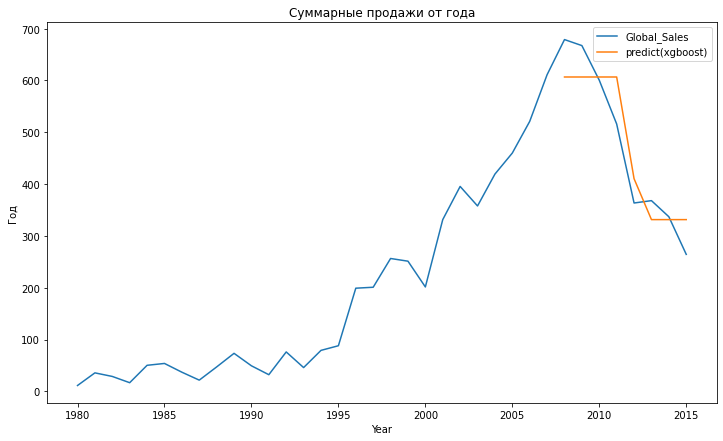

In [47]:
model = xgb.XGBRegressor()

model.fit(Val_train.drop('Global_Sales',axis = 1), Val_train.Global_Sales)
pred = model.predict(Val_test.drop('Global_Sales',axis = 1))
plt.title('Суммарные продажи от года')
plt.xlabel('Суммарные продажи')
plt.ylabel('Год')
Val.Global_Sales.plot()
plt.plot(Val_test.index,pred,label = 'predict(xgboost)')
plt.legend()
print('MSE: ',mean_absolute_error(Val_test.Global_Sales,pred))

Получена средняя аппроксимация

Рассмотрим ошибку на кросс валидации для предустановленных параметров по всей выборке

In [48]:
model = xgb.XGBRegressor()
cross_val(Val,model)

96.37414079454085

Добавим еще один лаг

In [49]:
Val_1 = all_par.drop('pred',axis = 1)
Val_1["lag1"] = Val_1.Global_Sales.shift(4)
Val_1["lag2"] = Val_1.Global_Sales.shift(8)
Val_1.dropna(inplace = True)

In [50]:
model = xgb.XGBRegressor()
cross_val(Val_1,model)

136.39678841727073

Видно, что качество уменьшилось, соответсвено - дополнительный лаг не нужен.

Подберем параметры xgboost на валидации

In [51]:
def brute_force(data):
    depts = np.arange(1,10)
    learning_rates = np.arange(0.01,0.21,0.01)
    n_estimators = np.arange(50,1050,50)
    errors = []
    for dept in depts:
        for learning_rate in learning_rates:
            for n_estimator in n_estimators:
                model = xgb.XGBRegressor(max_depth = dept,
                                         learning_rate = learning_rate,
                                         n_estimators = n_estimator)
                errors.append([cross_val(data,model),dept,learning_rate,n_estimator])
    return errors

In [52]:
# Val = all_par.drop('pred',axis = 1)
# Val["lag"] = Val.Global_Sales.shift(4)
# Val.dropna(inplace = True)

In [53]:
errors = brute_force(Val_train)

In [54]:
_,depth_b,learn_b, samples_b= min(errors)

MSE:  49.343902282714716


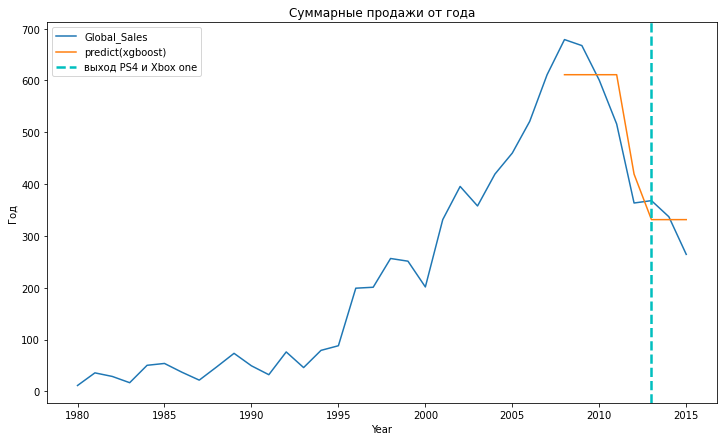

In [72]:
model = xgb.XGBRegressor(max_depth = depth_b,
                        learning_rate = learn_b,
                        n_estimators  = samples_b)

model.fit(Val_train.drop('Global_Sales',axis = 1), Val_train.Global_Sales)
pred = model.predict(Val_test.drop('Global_Sales',axis = 1))
plt.title('Суммарные продажи от года')
plt.xlabel('Суммарные продажи')
plt.ylabel('Год')
Val.Global_Sales.plot()
plt.plot(Val_test.index,pred,label = 'predict(xgboost)')
plt.axvline(2013, color='c', linestyle='dashed', linewidth=2.5,label = 'выход PS4 и Xbox one')
plt.legend()
print('MSE: ',mean_absolute_error(Val_test.Global_Sales,pred))

ошибка немного выросла, скорее всего это связано с тем, что до этого тренд возрастал, однако, на тесте он падает

### Построение модели SARIMA

Найдем параметры для дифференцирования времянного ряда

In [56]:
Sar = all_par.drop('pred',axis = 1)
tr_size = np.int64(Sar.shape[0]*0.8)
Sar_train = Sar.iloc[:tr_size]
Sar_test = Sar.iloc[tr_size:]

In [57]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 4, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

Для проверки стационарности ряда воспользуемся тестом Дикки-Фуллера с уровнем значимости 

1. Н0 - ряд не стационарен
2. Н1 - стационарен

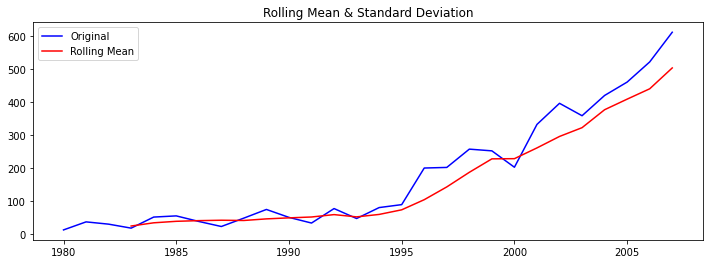

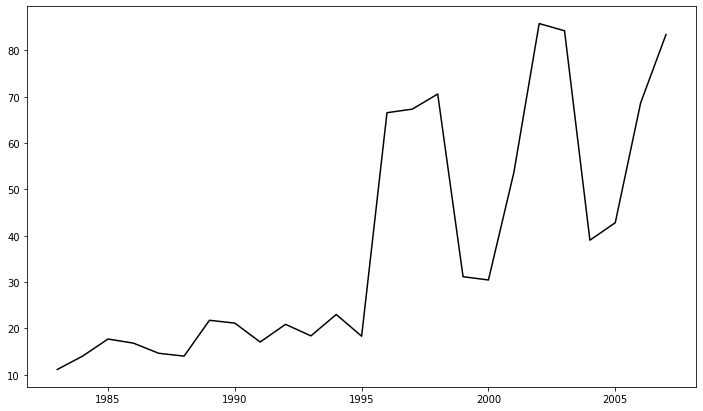

Results of Dickey-Fuller Test:
p-value = 1.0000. The series is likely non-stationary.
Test Statistic                  2.802616
p-value                         1.000000
#Lags Used                      2.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


In [58]:
# test_stationarity(Sar_train.Global_Sales,window = 4)
test_stationarity(Sar_train.Global_Sales,window = 4)

Ряд не стационарен, так как p>>0.05

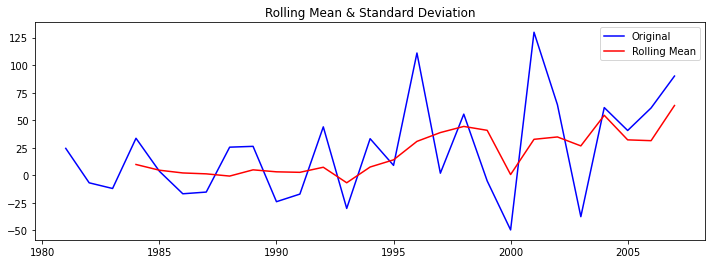

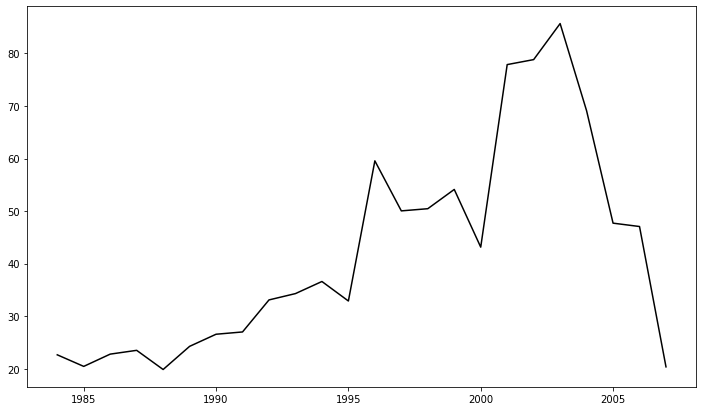

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                 -5.214432
p-value                         0.000008
#Lags Used                      0.000000
Number of Observations Used    26.000000
Critical Value (1%)            -3.711212
Critical Value (5%)            -2.981247
Critical Value (10%)           -2.630095
dtype: float64


In [59]:
Global_train_sh = Sar_train.Global_Sales - Sar_train.Global_Sales.shift(1)
Global_train_sh.dropna(inplace = True)
test_stationarity(Global_train_sh)
# Global_train_sh = Sar.Global_Sales - Sar.Global_Sales.shift(1)
# Global_train_sh.dropna(inplace = True)
# test_stationarity(Global_train_sh)

Получился стационарный ряд, соответственно, параметры для диффиеренцирования следующие:  
d = 1  
D = 0 (так как не смещали на сезон)

Подберем авторегрессионные компоненты

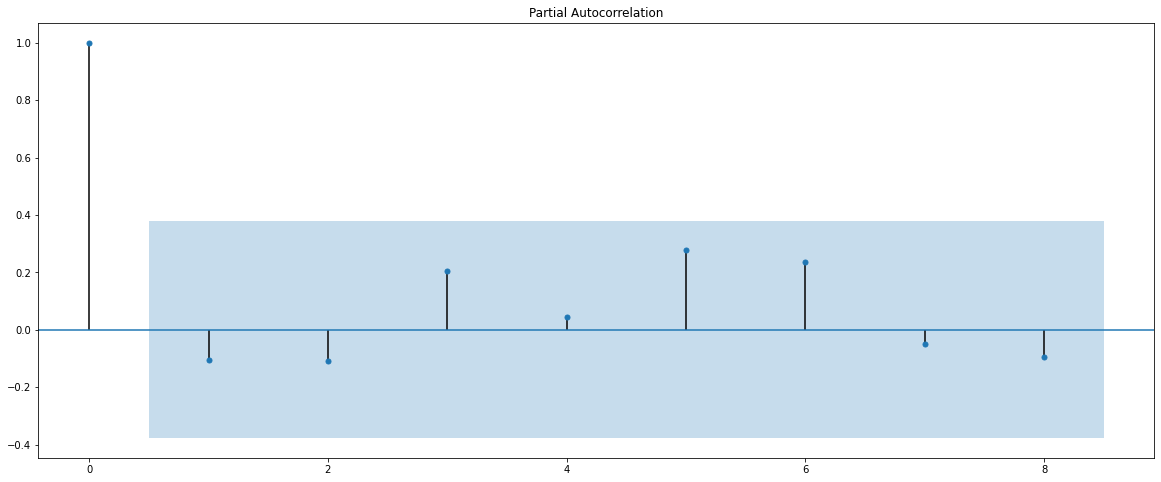

In [60]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_pacf(Global_train_sh.values, lags=8,ax = ax,alpha=0.05)
plt.show()

На данном графике видно, что P,p = 0, так как ни один из лагов не вышел за пределы времянного ряда

Рассмотрим МА компоненты

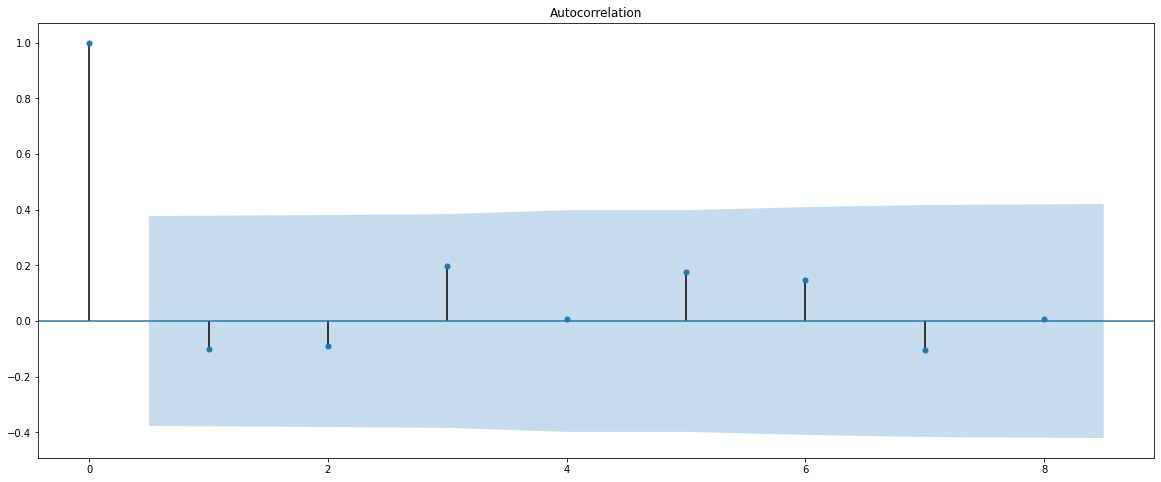

In [61]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(Global_train_sh.values, lags=8,ax = ax)
plt.show()

Опять же Q,q = 0

Построение прогноза, такие авторегрессионные параметры выглядят не очень, поэтому просто постараемся их подобрать

In [62]:
d = 1
D = 0
ps = range(0, 2)
qs = range(0, 2)
Ps = range(0, 2)
Qs = range(0, 2)

In [63]:
from itertools import product
import time
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)
%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=SARIMAX(Sar_train.Global_Sales,exog = Sar_train.Name , order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 0 ns


In [64]:
best_param # Все же p,q получились не равными 0

(0, 1, 0, 0)

In [65]:
print(best_model.summary().tables[0])

                               SARIMAX Results                                
Dep. Variable:           Global_Sales   No. Observations:                   28
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -131.411
Date:                Fri, 08 May 2020   AIC                            268.823
Time:                        20:35:50   BIC                            272.710
Sample:                             0   HQIC                           269.979
                                 - 28                                         
Covariance Type:                  opg                                         


Изучим остатки модели:

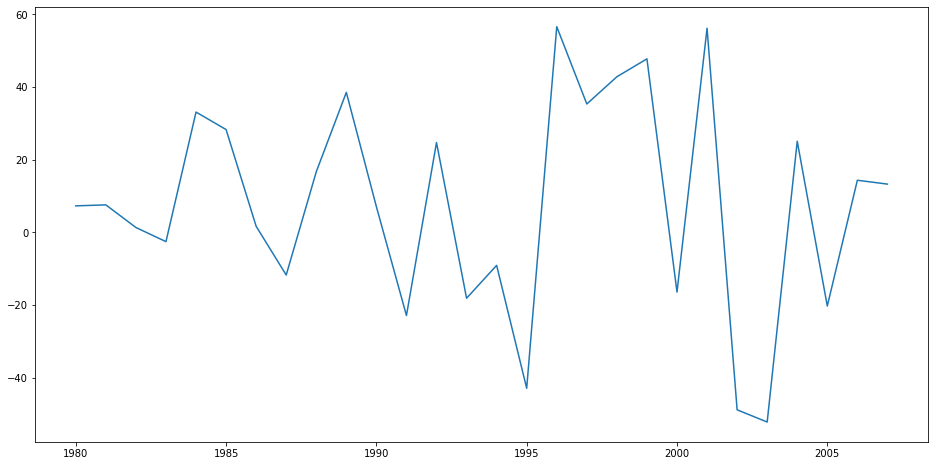

Тест Шаптро-Улки:  (0.9724656343460083, 0.6480129361152649)
Тест Дикки-Фуллера:  (-2.402955006018279, 0.14090411651925117, 9, 18, {'1%': -3.859073285322359, '5%': -3.0420456927297668, '10%': -2.6609064197530863}, 179.60011975810914)


In [66]:
# Остатки модели
plt.figure(figsize=(16,8))
plt.plot(best_model.resid)
plt.show()
"""
Проверим стационарны ли остатки с помощью теста Дикки-Фуллера и нормальны ли они 
с помощью теста Шапиро - Уилки, везде уровень значимости 5%
"""
print(u"Тест Шаптро-Улки: ",stats.shapiro(best_model.resid))
print(u'Тест Дикки-Фуллера: ',sm.tsa.adfuller(best_model.resid))

Остатки модели нормальные, однако ряд остатков не стационарен.

In [67]:
forecast = best_model.predict(start = Sar_train.shape[0], end = Sar_train.shape[0]+ Sar_test.shape[0]-1,exog = Sar_test.Name)

C:\Users\willi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\willi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:587: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  ' exception.', DeprecationWarning)


MSE: 38.52377364416131


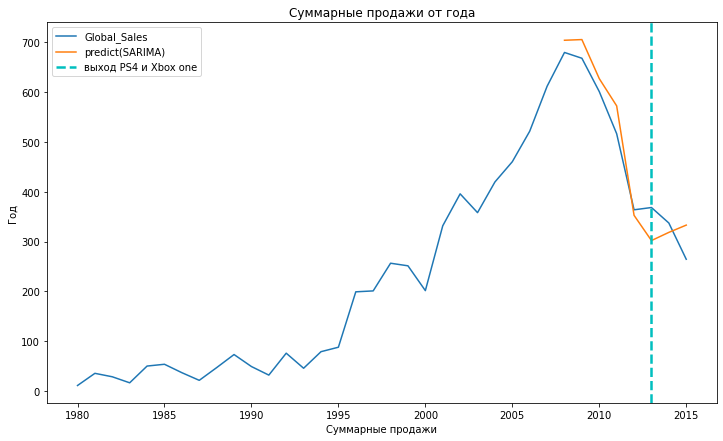

In [68]:
Sar.Global_Sales.plot()
plt.plot(Sar_test.index,forecast,label = 'predict(SARIMA)')
plt.title('Суммарные продажи от года')
plt.xlabel('Суммарные продажи')
plt.ylabel('Год')
plt.axvline(2013, color='c', linestyle='dashed', linewidth=2.5,label = 'выход PS4 и Xbox one')
plt.legend()
print('MSE:', mean_absolute_error(Sar_test.Global_Sales,forecast))

Аппроксимируем нашу тестовую выборку с помощью SARIMA. Видно, что модель сильно ошибается в 2013 году, когда вышли Xbox One и PS4.

MSE: 25.106487334938205


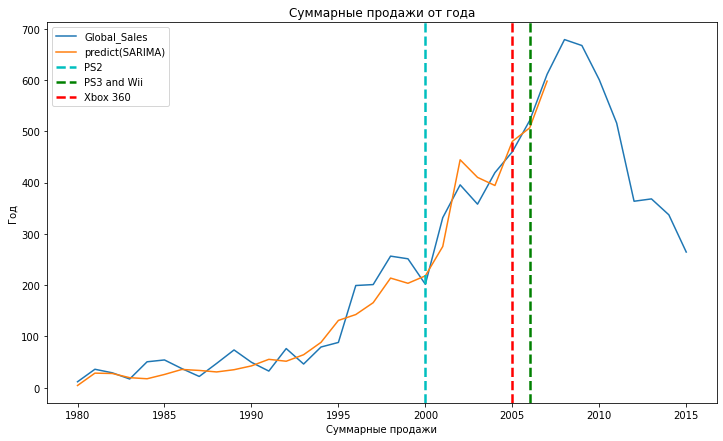

In [69]:
forecast = best_model.predict(start = 0, end = Sar_train.shape[0]-1,exog = Sar_train.Name)
Sar.Global_Sales.plot()
plt.plot(Sar_train.index,forecast,label = 'predict(SARIMA)')
plt.title('Суммарные продажи от года')
plt.xlabel('Суммарные продажи')
plt.ylabel('Год')
plt.axvline(2000, color='c', linestyle='dashed', linewidth=2.5,label = 'PS2')
plt.axvline(2006, color='g', linestyle='dashed', linewidth=2.5,label = 'PS3 and Wii')
plt.axvline(2005, color='r', linestyle='dashed', linewidth=2.5,label = 'Xbox 360')

plt.legend()
print('MSE:', mean_absolute_error(Sar_train.Global_Sales,forecast))

По данному графику видно, что до 2008 года упадки на графиков происходили не из-за уменьшения интереса юзеров к видео играм, а из-за того, что в прошлые годы интерес был не обычно высок(выход новых платформ и тд). Однако, по предсказанному за перид с 2014 по 2015 год так сказать нельзя, так как падение оказалось очень сильным.

## Выводы:

В ходе проведенного исследование были получены следующие инсайты:  
1. Средние продажи игр по годам увеличились в период с 1998 по 2016 год, что связано, как с увеличением количества популярных игр, так и с увеличением, в среднем, продаж каждой из игр в этот период
2. У времянного ряда зависимости продаж от времени наблюдается ярко выраженная сезонность, равная 4 годам. Данную сезонность можно обосновать тем, что, в среднем, новые популярные пталформы, такие как Sony PS, Wii,Xbox обновляются раз в 4 года.
3. Большинство выпускаемых игр в периоды с 1980 по 2016 имели продажи менее 2 млн долларов
4. Видно, что модель SARIMA и xgboost ожидают уменьшения продаж в 2013 году, однако, продажиЮ на самом деле, росли. Это связано с выходом в 2013 PS3 и Xbox One, что небыло учтено моделью. 
5. В период с 2008 по 2012 год падение рынка видео игр было обусловлено лишь тем, что количество выпускаемых популярных(качественных) игр уменьшилось. В тот период давольно прибыльным был выпуск Инди игр, продажи которых не так высоки, однако затраты минимальны, из-за чего небольшие компании начали выпускать именно их. 
6. Реальный упадок в период с 2014 по 2015 говорит о снижении интереса потребителей к выпускаемым в тот период играм, которого раньше сильно не наблюдалось 
7. Видно, что сильный рост рынка видео игр начался именно после выхода PS2.
8. В перид с 2002 по 2003 год рынок видео игр тоже непрсказуемо упал, что, скорее всего связано с недостаточным количеством очень популярных видео игр, вышедших в тот период
9. Мне кажется, если добавить в модель инсайты о выходе новых популярных консолей - ее качество улучшиться.
10. Зависимости общих продаж от того, была ли в данный год выпущена сверх популярная игра(продажи более 10 млн), практически нет. Однако есть сильная зависимость от колличества игр, из чего можно сделать вывод, что можно предсказывать поведение рынка видео игр, с достаточно высокой точность, лишь зная сколько игр было выпущено и выходили ли новые версии популярных консолей.